<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

## Capstone Project: Unsupervised Text Clustering using Natural Language Processing (NLP)

### Problem Statement

Unsupervised learning is a type of algorithm that learns patterns from untagged data. As part of unsupervised learning, clustering is used to group similar data points without knowing which cluster the data belong to. So in a sense, text clustering is about how similar texts (or sentences) are grouped together. 

In this project, we would explore a text dataset that comprises of comments that donors left after donating to charity campaigns on Give.asia. Founded in 2009. Give.asia is Asia's leading free fundraising platform for fundraisers to raise money for their causes. This social enterprise have helped more than 20,000 campaigns across APAC, raising more than SGD$100 million. 

We hope that we can use unsupervised machine learning models to find groups of similar instances in the text data (clustering), and potentially find out if there are common aspects in donors for the reason/s of giving. With these insights, we can potentially shape future donor's engagement or donor journey maps. 

## Content

This notebook will be broken down into different sections: 

1. Exploratory Data Analysis on Comments

2. Text Preprocessing
    - Language Detection
    - Data Cleaning: Removal of digits, punctuations, additional spaces
    - Lemmatizing & Porter-stemmed the text 
    - Returns cleaned list

3. Text Feature Extraction
    - CountVectorizer
    - TF-IDF

4. Clustering Algorithm & Evaluation
    - KMeans Clustering
    - DBSCAN
    
5. Topic Modeling with Latent Dirichlet Allocation (LDA)

6. Conclusion and Recommendation



In [1]:
#!pip install pyLDAvis
#pip install langdetect
#pip install numpy==1.21.4
#pip install kneed

In [2]:
import numpy
numpy.__version__

'1.21.4'

In [3]:
# Imports
import numpy as np
from numpy import unique, where
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
import re
nltk.download('wordnet')
nltk.download('stopwords')


from wordcloud import WordCloud
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from langdetect import detect
from langdetect import DetectorFactory
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score,  v_measure_score
from sklearn.decomposition import PCA
from kneed import KneeLocator

%matplotlib inline

# Do not display future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/shuxiangoh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shuxiangoh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
#Set viewing options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### 1. Exploratory Data Analysis on Comments

In [5]:
#read file
df = pd.read_csv('../dataset/donation_reason.csv')
df.head()

,comment,currency,amount
0,"Imagine you are Joceline’s parent, you’ll defi...",MYR,50000
1,My prayers will always be with you sayang ❤.. ...,SGD,2000
2,"Everyone, please donate any amount that you ca...",SGD,5000
3,This breaks my heart seeing a young baby like ...,SGD,1000
4,My baby is 1 month younger then Niyaz. And I c...,SGD,5000


In [6]:
df.shape

(1000, 3)

In [7]:
#sample of what's in the content
df['comment'][0]

'Imagine you are Joceline’s parent, you’ll definitely wish Joceline to get treatments, you wish someone can help you, someone can donate to you. Pray for Joceline will get better.'

In [8]:
#explore the percentage of currency donated in sgd
y = df['currency'].value_counts(normalize = True)
mylabels = ['SGD', 'MYR', 'VND', 'USD', 'INR','THB', 'HKD']

In [9]:
y

SGD    0.835
MYR    0.112
VND    0.022
USD    0.016
INR    0.011
THB    0.003
HKD    0.001
Name: currency, dtype: float64

In [10]:
#to emphasize SGD part of the pie chart
myexplode = [0.835, 0, 0, 0, 0, 0, 0]

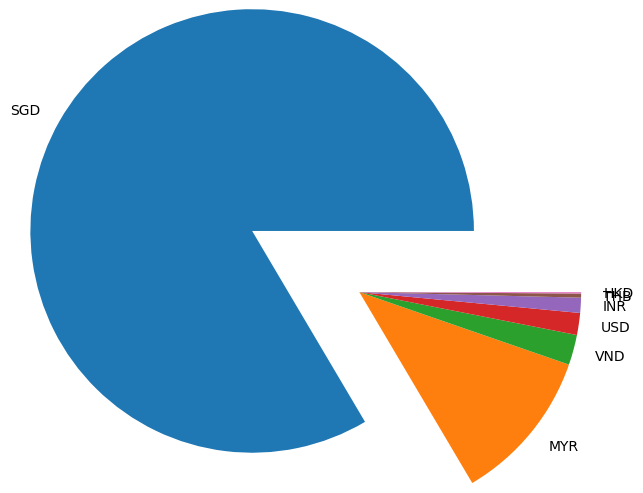

In [11]:
#visualization
plt.pie(y, labels = mylabels, explode = myexplode, radius = 1.5)
plt.show()

In [12]:
#explore donation amount in sgd
df_sgd = df[df['currency']=='SGD']
df_sgd

,comment,currency,amount
1,My prayers will always be with you sayang ❤.. ...,SGD,2000
2,"Everyone, please donate any amount that you ca...",SGD,5000
3,This breaks my heart seeing a young baby like ...,SGD,1000
4,My baby is 1 month younger then Niyaz. And I c...,SGD,5000
5,Because it is the right thing to do.,SGD,50000
...,...,...,...
995,hope he gets better soon,SGD,2000
996,希望你能康复与家人相聚，加油你行的,SGD,5000
997,Hope he will get well soon！,SGD,1000
998,加油。加油。家人都在等着你啊。,SGD,5000


In [13]:
df_sgd['amount'].describe()

count       835.000000
mean       8673.113772
std       15382.825606
min         100.000000
25%        2000.000000
50%        5000.000000
75%       10000.000000
max      216000.000000
Name: amount, dtype: float64

In [14]:
df_sgd['comment'][df_sgd['amount'] == 216000]

114    God bless you all I will try to help more when...
Name: comment, dtype: object

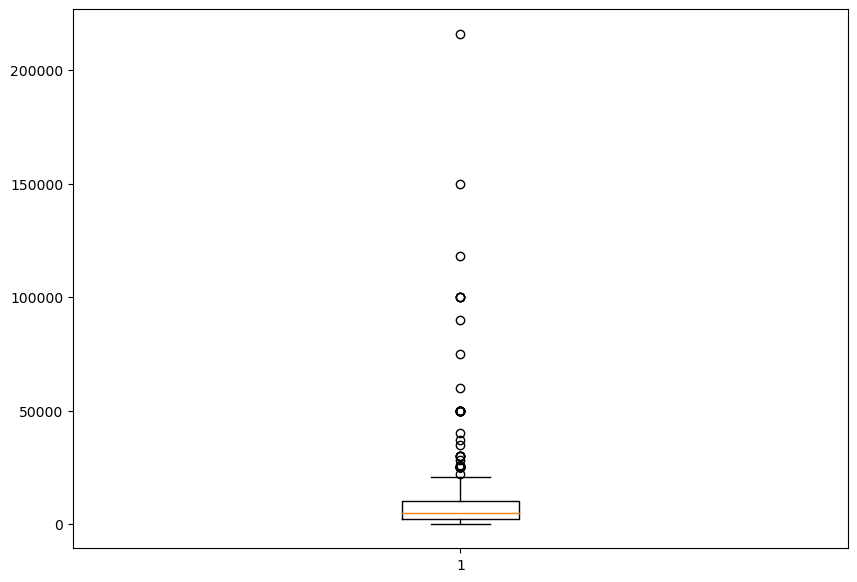

In [15]:
fig = plt.figure(figsize =(10, 7))
 
# Creating boxplot for donation amount in sgd
plt.boxplot(df_sgd['amount'])
 
# show plot
plt.show()

In [16]:
#explore donation amount in myr
df_myr = df[df['currency']=='MYR']
df_myr

,comment,currency,amount
0,"Imagine you are Joceline’s parent, you’ll defi...",MYR,50000
18,My dad had the same condition,MYR,50000
21,Just paying forward.,MYR,200000
26,I hope that this small amount of money will he...,MYR,1500
28,I want to give back to society.,MYR,20000
29,"Hope the little girl recover soon, be strong m...",MYR,5000
47,Hope can help some,MYR,5000
51,I donated because it hurts me to see little ch...,MYR,5000
52,Hope can help some,MYR,5000
61,I hope she'll get well soon ♡,MYR,1000


In [17]:
df_myr['amount'].describe()

count       112.000000
mean      24130.357143
std       37771.131164
min        1000.000000
25%        7950.000000
50%       18000.000000
75%       20000.000000
max      320000.000000
Name: amount, dtype: float64

In [18]:
df_myr['comment'][df_myr['amount'] == 320000]

177    Our hearts are with you, we pray and hope Joce...
Name: comment, dtype: object

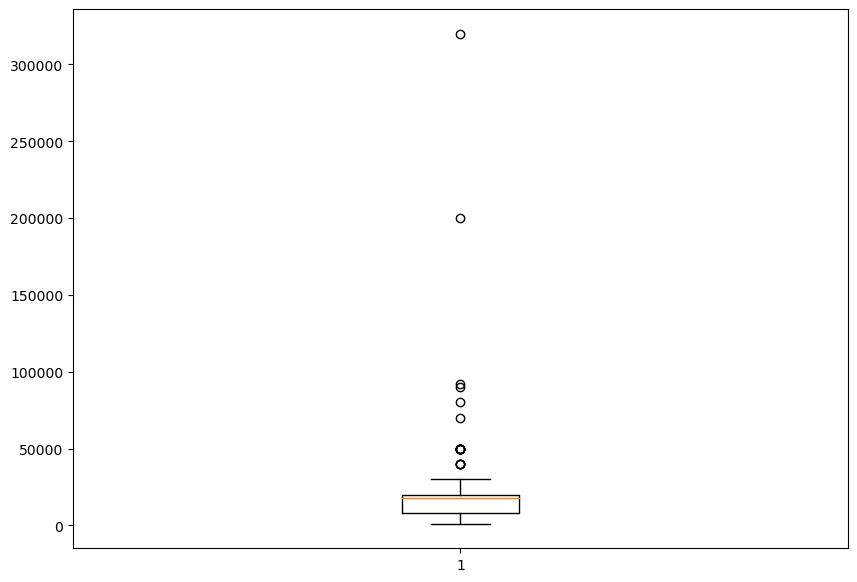

In [19]:
fig = plt.figure(figsize =(10, 7))
 
# Creating boxplot for donation amount in myr
plt.boxplot(df_myr['amount'])
 
# show plot
plt.show()

#### Post Length

In [20]:
df['text_length'] = df['comment'].str.len()

In [21]:
df['text_wordcount']= df['comment'].str.count(' ')+1

In [22]:
df.sort_values(by=['text_wordcount'], ascending = False)[['comment', 'text_length', 'text_wordcount']].head(10)

,comment,text_length,text_wordcount
17,I donated because I wanted to help this poor c...,240.0,49.0
31,"I hope with the amount i give, it will help th...",239.0,49.0
75,I am saddened to see a young boy like Manidhar...,233.0,47.0
19,i donated because it might be just a simple ac...,220.0,47.0
150,I'm a mother of 3 and also a nurse...it hurts ...,234.0,47.0
330,My cousin had leukemia and he passed on at the...,237.0,47.0
368,"My colleague many years ago , from Myanmar, wa...",233.0,47.0
554,My parents are Malaysians my mum also worked i...,237.0,45.0
849,I was a former Malaysian working in Singapore ...,238.0,45.0
3,This breaks my heart seeing a young baby like ...,211.0,45.0


In [23]:
df.sort_values(by=['text_wordcount'], ascending = True)[['comment', 'text_length', 'text_wordcount']].head(10)

,comment,text_length,text_wordcount
953,为家人积福,5.0,1.0
493,希望他早日康复。可以回家跟家人团聚。,18.0,1.0
485,Gambateh,8.0,1.0
482,希望病患早日康复,8.0,1.0
629,小小心意🙏🙏🙏,7.0,1.0
630,我希望他可以度过这个难关，有福气活到终老。人活在世上不容易，更何况离乡背井，独自一个人打拼，...,83.0,1.0
87,🥰🥰🥰,3.0,1.0
475,加油,2.0,1.0
640,♥️♥️,4.0,1.0
82,🥰🥰🥰,3.0,1.0


Text(0.5, 1.0, 'Frequency of wordcounts')

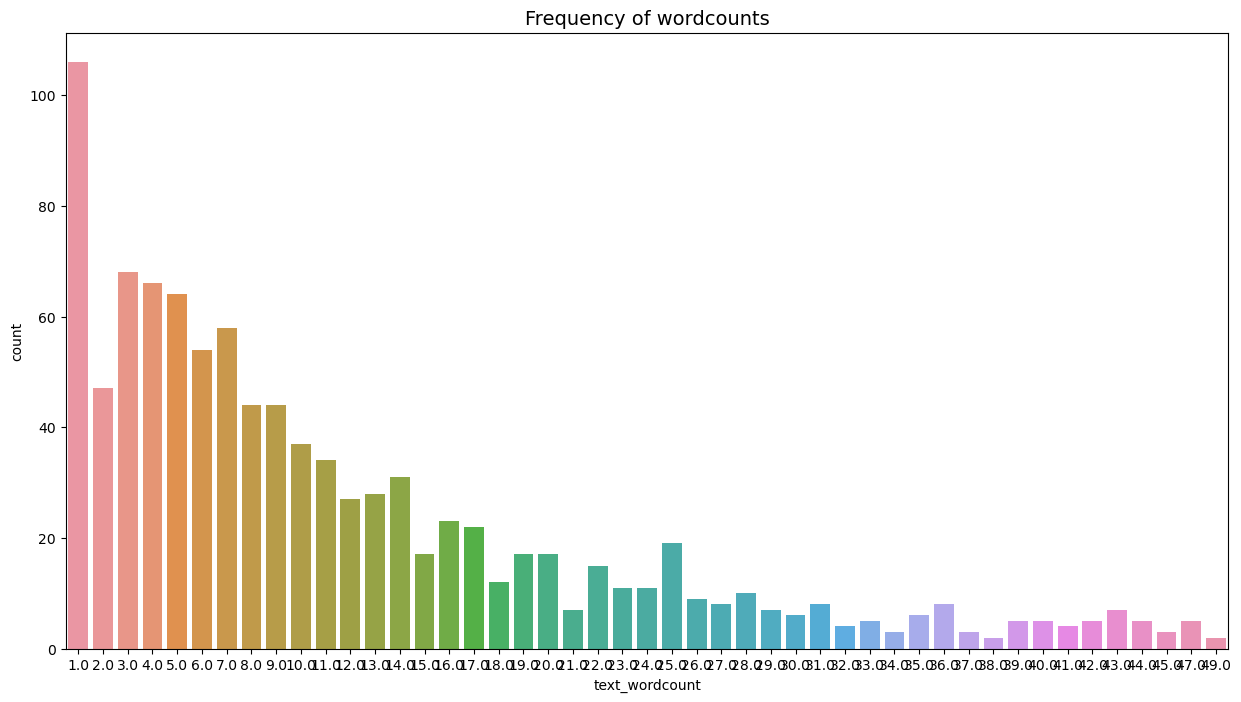

In [24]:
plt.figure(figsize = (15,8))
ax = sns.countplot(x ='text_wordcount', data = df)
plt.title("Frequency of wordcounts", size = 14)

**Observations:**

The highest occurring word count is 1, and majority of the comments have less than 20 words. 

In [25]:
df['text_wordcount'].describe()

count    999.000000
mean      11.887888
std       10.756805
min        1.000000
25%        4.000000
50%        8.000000
75%       17.000000
max       49.000000
Name: text_wordcount, dtype: float64

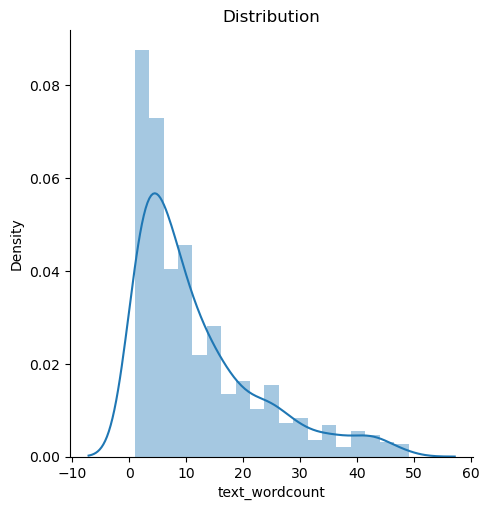

In [26]:
plot = sns.FacetGrid(df, height = 5)
plot = plot.map(sns.distplot, 'text_wordcount')
plt.title('Distribution')
plt.ylabel('Density');

### 2. Text Preprocessing

#### Language Detection

In [27]:
#language detection algorithm is non-deterministic
#if the text is either too short or too ambiguous, you might get different results every time you run it
#to enforce consistent results, call the following code
DetectorFactory.seed = 0

def detect_my(text):
    try:
        return detect(text)
    except:
        return 'unknown'

In [28]:
df['language'] = df['comment'].apply(detect_my) 

In [29]:
df.head()

,comment,currency,amount,text_length,text_wordcount,language
0,"Imagine you are Joceline’s parent, you’ll defi...",MYR,50000,178.0,29.0,en
1,My prayers will always be with you sayang ❤.. ...,SGD,2000,74.0,14.0,en
2,"Everyone, please donate any amount that you ca...",SGD,5000,77.0,13.0,en
3,This breaks my heart seeing a young baby like ...,SGD,1000,211.0,45.0,en
4,My baby is 1 month younger then Niyaz. And I c...,SGD,5000,163.0,31.0,en


In [30]:
df['language'].unique()

array(['en', 'id', 'vi', 'et', 'cy', 'so', 'ko', 'zh-cn', 'af', 'tl',
       'ro', 'unknown', 'sw', 'zh-tw', 'no', 'it', 'fr', 'nl', 'da', 'pl',
       'pt', 'de', 'tr', 'lv', 'sv', 'hr'], dtype=object)

In [31]:
#see the percentage of comments in en (english)
df['language'].value_counts(normalize = True)

en         0.780
zh-cn      0.055
ko         0.026
af         0.024
vi         0.016
unknown    0.013
nl         0.012
ro         0.010
id         0.009
tl         0.008
et         0.008
sw         0.006
it         0.006
de         0.004
so         0.004
cy         0.003
fr         0.003
da         0.003
lv         0.002
zh-tw      0.002
pt         0.001
pl         0.001
tr         0.001
no         0.001
sv         0.001
hr         0.001
Name: language, dtype: float64

In [32]:
df[df['language']=='sv']

,comment,currency,amount,text_length,text_wordcount,language
687,Fulfilling my obligations,SGD,17500,25.0,3.0,sv


In [33]:
df[df['language']=='no']

,comment,currency,amount,text_length,text_wordcount,language
174,Kindness matters,SGD,10000,16.0,2.0,no


In [34]:
df[df['language']!= 'en']

,comment,currency,amount,text_length,text_wordcount,language
9,I just wanna help people to get a better life ...,VND,250000,159.0,29.0,id
23,"ta là người Việt Nam, lá lành đùm lá rách muôn...",VND,100000,55.0,13.0,vi
32,bakes 2 - F2E101T1,SGD,3100,18.0,4.0,et
43,My prayers for you kiddo.,SGD,10000,25.0,5.0,cy
45,In Syaa Allah,SGD,4000,13.0,3.0,so
46,加油,SGD,5000,2.0,1.0,ko
53,Semoga Allah permudahkan segala urusan. Amiin.,SGD,10000,46.0,6.0,id
57,每个月都以自己小小心意帮助这些小宝宝们，祝愿小宝宝们早日康复，快乐健康成长。阿弥陀佛🙏,SGD,5000,43.0,1.0,zh-cn
58,Be strong! Get well soon,SGD,10000,24.0,5.0,af
65,Stay strong baby ❤️,SGD,3000,19.0,4.0,tl


We noticed that the language detection is inaccurate in detecting english language as there are quite a few instances with wrong translation. We can clean the comments by removing emoticons and punctuations to see if it improves the detection of language. 

#### Data Cleaning 
When dealing with text data, there are common pre-processing steps. 
- Remove special characters
- Tokenizing

We can combine the steps for removal of unnecessary characters when cleaning text data (punctuation, symbols, etc) and splitting text data into distinct chunks based on some pattern using RegEx tokenizer. 

In [35]:
df.comment = df.comment.astype(str)

In [36]:
#Define a function to clean text data 
#remove whitespace, keep only alphabet characters and make lowercase

col_list = ['comment']

def tokenize_data(data, col_list):
    tokenizer = RegexpTokenizer(r'[a-zA-ZИ]+')
    
    for col in col_list:
        tokenized_items = [tokenizer.tokenize(item.lower()) for item in data[col]]
        data[f'tokenized_{col}'] = tokenized_items
    return data

In [37]:
df = tokenize_data(df, col_list)
df.head()

,comment,currency,amount,text_length,text_wordcount,language,tokenized_comment
0,"Imagine you are Joceline’s parent, you’ll defi...",MYR,50000,178.0,29.0,en,"[imagine, you, are, joceline, s, parent, you, ..."
1,My prayers will always be with you sayang ❤.. ...,SGD,2000,74.0,14.0,en,"[my, prayers, will, always, be, with, you, say..."
2,"Everyone, please donate any amount that you ca...",SGD,5000,77.0,13.0,en,"[everyone, please, donate, any, amount, that, ..."
3,This breaks my heart seeing a young baby like ...,SGD,1000,211.0,45.0,en,"[this, breaks, my, heart, seeing, a, young, ba..."
4,My baby is 1 month younger then Niyaz. And I c...,SGD,5000,163.0,31.0,en,"[my, baby, is, month, younger, then, niyaz, an..."


In [38]:
#try langdetect on tokenized_comment
df['tc_series'] = df['tokenized_comment'].apply(lambda row: ' '.join(row))
df['language'] = df['tc_series'].apply(detect_my) 

In [39]:
df['language'].value_counts(normalize = True)

en         0.751
unknown    0.095
af         0.028
nl         0.020
vi         0.015
no         0.011
cy         0.010
ro         0.009
sw         0.008
tl         0.007
it         0.007
id         0.007
so         0.004
fr         0.004
da         0.003
ca         0.003
sl         0.003
hr         0.002
de         0.002
sq         0.002
fi         0.002
pl         0.002
tr         0.002
et         0.001
cs         0.001
sk         0.001
Name: language, dtype: float64

In [40]:
df[df['language']!= 'en']

,comment,currency,amount,text_length,text_wordcount,language,tokenized_comment,tc_series
9,I just wanna help people to get a better life ...,VND,250000,159.0,29.0,id,"[i, just, wanna, help, people, to, get, a, bet...",i just wanna help people to get a better life ...
23,"ta là người Việt Nam, lá lành đùm lá rách muôn...",VND,100000,55.0,13.0,vi,"[ta, l, ng, i, vi, t, nam, l, l, nh, m, l, r, ...",ta l ng i vi t nam l l nh m l r ch mu n i
32,bakes 2 - F2E101T1,SGD,3100,18.0,4.0,no,"[bakes, f, e, t]",bakes f e t
43,My prayers for you kiddo.,SGD,10000,25.0,5.0,cy,"[my, prayers, for, you, kiddo]",my prayers for you kiddo
45,In Syaa Allah,SGD,4000,13.0,3.0,so,"[in, syaa, allah]",in syaa allah
46,加油,SGD,5000,2.0,1.0,unknown,[],
53,Semoga Allah permudahkan segala urusan. Amiin.,SGD,10000,46.0,6.0,id,"[semoga, allah, permudahkan, segala, urusan, a...",semoga allah permudahkan segala urusan amiin
57,每个月都以自己小小心意帮助这些小宝宝们，祝愿小宝宝们早日康复，快乐健康成长。阿弥陀佛🙏,SGD,5000,43.0,1.0,unknown,[],
58,Be strong! Get well soon,SGD,10000,24.0,5.0,af,"[be, strong, get, well, soon]",be strong get well soon
65,Stay strong baby ❤️,SGD,3000,19.0,4.0,tl,"[stay, strong, baby]",stay strong baby


In [41]:
#drop rows with unknown language
df.drop(df.loc[df['language']=='unknown'].index, inplace = True)

In [42]:
df[df['language']!= 'en']

,comment,currency,amount,text_length,text_wordcount,language,tokenized_comment,tc_series
9,I just wanna help people to get a better life ...,VND,250000,159.0,29.0,id,"[i, just, wanna, help, people, to, get, a, bet...",i just wanna help people to get a better life ...
23,"ta là người Việt Nam, lá lành đùm lá rách muôn...",VND,100000,55.0,13.0,vi,"[ta, l, ng, i, vi, t, nam, l, l, nh, m, l, r, ...",ta l ng i vi t nam l l nh m l r ch mu n i
32,bakes 2 - F2E101T1,SGD,3100,18.0,4.0,no,"[bakes, f, e, t]",bakes f e t
43,My prayers for you kiddo.,SGD,10000,25.0,5.0,cy,"[my, prayers, for, you, kiddo]",my prayers for you kiddo
45,In Syaa Allah,SGD,4000,13.0,3.0,so,"[in, syaa, allah]",in syaa allah
53,Semoga Allah permudahkan segala urusan. Amiin.,SGD,10000,46.0,6.0,id,"[semoga, allah, permudahkan, segala, urusan, a...",semoga allah permudahkan segala urusan amiin
58,Be strong! Get well soon,SGD,10000,24.0,5.0,af,"[be, strong, get, well, soon]",be strong get well soon
65,Stay strong baby ❤️,SGD,3000,19.0,4.0,tl,"[stay, strong, baby]",stay strong baby
67,I care,SGD,5000,6.0,2.0,ro,"[i, care]",i care
69,Bakes 2 - F2E100T1,SGD,2500,18.0,4.0,no,"[bakes, f, e, t]",bakes f e t


In [43]:
#further inspection, vietnamese (vi) language is accurate
#continue to drop rows with 'vi'

df.drop(df.loc[df['language']=='vi'].index, inplace = True)

In [44]:
df[df['language']!= 'en']

,comment,currency,amount,text_length,text_wordcount,language,tokenized_comment,tc_series
9,I just wanna help people to get a better life ...,VND,250000,159.0,29.0,id,"[i, just, wanna, help, people, to, get, a, bet...",i just wanna help people to get a better life ...
32,bakes 2 - F2E101T1,SGD,3100,18.0,4.0,no,"[bakes, f, e, t]",bakes f e t
43,My prayers for you kiddo.,SGD,10000,25.0,5.0,cy,"[my, prayers, for, you, kiddo]",my prayers for you kiddo
45,In Syaa Allah,SGD,4000,13.0,3.0,so,"[in, syaa, allah]",in syaa allah
53,Semoga Allah permudahkan segala urusan. Amiin.,SGD,10000,46.0,6.0,id,"[semoga, allah, permudahkan, segala, urusan, a...",semoga allah permudahkan segala urusan amiin
58,Be strong! Get well soon,SGD,10000,24.0,5.0,af,"[be, strong, get, well, soon]",be strong get well soon
65,Stay strong baby ❤️,SGD,3000,19.0,4.0,tl,"[stay, strong, baby]",stay strong baby
67,I care,SGD,5000,6.0,2.0,ro,"[i, care]",i care
69,Bakes 2 - F2E100T1,SGD,2500,18.0,4.0,no,"[bakes, f, e, t]",bakes f e t
83,Bakes 2 - F2E96T1,SGD,2300,17.0,4.0,no,"[bakes, f, e, t]",bakes f e t


In [45]:
#looks like the language detected for non english are still mainly english
#we can omit non-english comments by taking note of the indexes

df = df.drop([45, 53, 232, 236, 624, 658, 758, 950])


In [46]:
df[df['language']!= 'en']

,comment,currency,amount,text_length,text_wordcount,language,tokenized_comment,tc_series
9,I just wanna help people to get a better life ...,VND,250000,159.0,29.0,id,"[i, just, wanna, help, people, to, get, a, bet...",i just wanna help people to get a better life ...
32,bakes 2 - F2E101T1,SGD,3100,18.0,4.0,no,"[bakes, f, e, t]",bakes f e t
43,My prayers for you kiddo.,SGD,10000,25.0,5.0,cy,"[my, prayers, for, you, kiddo]",my prayers for you kiddo
58,Be strong! Get well soon,SGD,10000,24.0,5.0,af,"[be, strong, get, well, soon]",be strong get well soon
65,Stay strong baby ❤️,SGD,3000,19.0,4.0,tl,"[stay, strong, baby]",stay strong baby
67,I care,SGD,5000,6.0,2.0,ro,"[i, care]",i care
69,Bakes 2 - F2E100T1,SGD,2500,18.0,4.0,no,"[bakes, f, e, t]",bakes f e t
83,Bakes 2 - F2E96T1,SGD,2300,17.0,4.0,no,"[bakes, f, e, t]",bakes f e t
86,Get well soon...,SGD,5000,16.0,3.0,af,"[get, well, soon]",get well soon
96,Bakes 2 - F2E95T1,SGD,3300,17.0,4.0,no,"[bakes, f, e, t]",bakes f e t


In [47]:
#manually remove row containing [bakes,f,e,t]
df.drop(df.loc[df['tc_series']=='bakes f e t'].index, inplace = True)

In [48]:
df[df['language']!= 'en']

,comment,currency,amount,text_length,text_wordcount,language,tokenized_comment,tc_series
9,I just wanna help people to get a better life ...,VND,250000,159.0,29.0,id,"[i, just, wanna, help, people, to, get, a, bet...",i just wanna help people to get a better life ...
43,My prayers for you kiddo.,SGD,10000,25.0,5.0,cy,"[my, prayers, for, you, kiddo]",my prayers for you kiddo
58,Be strong! Get well soon,SGD,10000,24.0,5.0,af,"[be, strong, get, well, soon]",be strong get well soon
65,Stay strong baby ❤️,SGD,3000,19.0,4.0,tl,"[stay, strong, baby]",stay strong baby
67,I care,SGD,5000,6.0,2.0,ro,"[i, care]",i care
86,Get well soon...,SGD,5000,16.0,3.0,af,"[get, well, soon]",get well soon
103,Get well soon,MYR,30000,13.0,3.0,af,"[get, well, soon]",get well soon
110,Jiayou!,SGD,3500,7.0,1.0,sw,[jiayou],jiayou
116,"Please get well soon, bro",SGD,5000,25.0,5.0,af,"[please, get, well, soon, bro]",please get well soon bro
131,Get well soon. God bless.,SGD,50000,25.0,5.0,af,"[get, well, soon, god, bless]",get well soon god bless


In [49]:
#drop unnecessary columns like language and tc_series
#prep df for other pre-processing steps
df.drop(columns = ['language', 'tc_series'], inplace = True)

In [50]:
df.dropna()

,comment,currency,amount,text_length,text_wordcount,tokenized_comment
0,"Imagine you are Joceline’s parent, you’ll defi...",MYR,50000,178.0,29.0,"[imagine, you, are, joceline, s, parent, you, ..."
1,My prayers will always be with you sayang ❤.. ...,SGD,2000,74.0,14.0,"[my, prayers, will, always, be, with, you, say..."
2,"Everyone, please donate any amount that you ca...",SGD,5000,77.0,13.0,"[everyone, please, donate, any, amount, that, ..."
3,This breaks my heart seeing a young baby like ...,SGD,1000,211.0,45.0,"[this, breaks, my, heart, seeing, a, young, ba..."
4,My baby is 1 month younger then Niyaz. And I c...,SGD,5000,163.0,31.0,"[my, baby, is, month, younger, then, niyaz, an..."
...,...,...,...,...,...,...
992,Hope he got chances go back to hometown and ga...,SGD,1000,72.0,14.0,"[hope, he, got, chances, go, back, to, hometow..."
994,Support to his family..,SGD,20000,23.0,4.0,"[support, to, his, family]"
995,hope he gets better soon,SGD,2000,24.0,5.0,"[hope, he, gets, better, soon]"
997,Hope he will get well soon！,SGD,1000,27.0,6.0,"[hope, he, will, get, well, soon]"


In [51]:
#final number of rows for modelling
df.shape

(874, 6)

In [52]:
cleaned_comments = df.copy(deep = False)

### Save data to csv file

In [53]:
#save file as csv
cleaned_comments.to_csv('../dataset/cleaned_comments.csv')

#### Lemmatizing and Stemming

*Lemmatizing* and *stemming* are two forms of shortening words so we can combine similar forms of the same word. When we "lemmatize" data, we take words and attempt to return their lemma, or the base/dictionary form of a word. When we "stem" data, we take words and attempt to return a base form of a word. It tends to be cruder than using lemmatization.  

**Explore Lemmatizing**

In [54]:
# Instantiate lemmatizer
lemmatizer = WordNetLemmatizer()

In [55]:
#Lemmatize tokens
def lem_text(row):
    return [lemmatizer.lemmatize(w) for w in row]

In [56]:
df['token_lem'] = df['tokenized_comment'].apply(lem_text)

In [57]:
df['token_lem']

0      [imagine, you, are, joceline, s, parent, you, ...
1      [my, prayer, will, always, be, with, you, saya...
2      [everyone, please, donate, any, amount, that, ...
3      [this, break, my, heart, seeing, a, young, bab...
4      [my, baby, is, month, younger, then, niyaz, an...
                             ...                        
992    [hope, he, got, chance, go, back, to, hometown...
994                           [support, to, his, family]
995                        [hope, he, get, better, soon]
997                    [hope, he, will, get, well, soon]
999                               [just, want, to, help]
Name: token_lem, Length: 874, dtype: object

In [58]:
#Example of lemmatized words in one row of dataframe
for num in range(len(df['tokenized_comment'][0])):
    if df['tokenized_comment'][0][num] != df['token_lem'][0][num]:
        print(df['tokenized_comment'][0][num], df['token_lem'][0][num])

treatments treatment


**Explore Stemming**

In [59]:
# Instantiate PorterStemmer
p_stemmer = PorterStemmer() 

In [60]:
#Stem tokens
def stem_text(row):
    return [p_stemmer.stem(w) for w in row]

df['token_pstem'] = df['tokenized_comment'].apply(stem_text)

In [61]:
df['token_pstem']

0      [imagin, you, are, jocelin, s, parent, you, ll...
1      [my, prayer, will, alway, be, with, you, sayan...
2      [everyon, pleas, donat, ani, amount, that, you...
3      [thi, break, my, heart, see, a, young, babi, l...
4      [my, babi, is, month, younger, then, niyaz, an...
                             ...                        
992    [hope, he, got, chanc, go, back, to, hometown,...
994                            [support, to, hi, famili]
995                        [hope, he, get, better, soon]
997                    [hope, he, will, get, well, soon]
999                               [just, want, to, help]
Name: token_pstem, Length: 874, dtype: object

In [62]:
#Example of stemmed words in one row of dataframe
for num in range(len(df['tokenized_comment'][0])):
    if df['tokenized_comment'][0][num] != df['token_pstem'][0][num]:
        print(df['tokenized_comment'][0][num], df['token_pstem'][0][num])

imagine imagin
joceline jocelin
definitely definit
joceline jocelin
treatments treatment
someone someon
someone someon
donate donat
joceline jocelin


### 3. Text Feature Extraction

Text themselves cannot be used by machine learning models. They expect their input to be numeric. So we need some way that can transform their input to be numeric. So we need some way that can transform input text into numeric feature in a meaningful way. Here are the 2 common approaches and we will highlight the advantages/ disavantages before deciding which approach to proceed. The choice of a specific vectorization technique will be largely driven by the problem space. 

   **i. CountVectorizer**

The simplest vector encoding model is to simply fill in the vector with the frequency of each word as it appears in the document. It is similar to #1 but instead of just checking if a word exists or not, it also checks how many times a word appeared.  

In this encoding scheme, each document is represented as the multiset of the tokens that compose it and the value for each word position in the vector is its count. This representation can either be a straight count (integer) encoding or a normalized encoding where each word is weighted by the total number of words in the document. This weighing scheme is not that useful for practical applications. Common words that occur frequently will have higher weight than others. 


   **ii. Term Frequency–Inverse Document Frequency (TF-IDF)**

TF-IDF encoding normalizes the frequency of tokens in a document with respect to the rest of the corpus. This encoding approach accentuates terms that are very relevant to a specific instance. TF–IDF is computed on a per-term basis, such that the relevance of a token to a document is measured by the scaled frequency of the appearance of the term in the document, normalized by the inverse of the scaled frequency of the term in the entire corpus. TF-IDF assigns more weight to less frequently occurring words rather than frequently occurring ones. It is based on the assumption that less frequently occurring words are more important. 

#### i. CountVectorizer with lemmatized and porter-stemmed cleaned data

In [63]:
df.head()

,comment,currency,amount,text_length,text_wordcount,tokenized_comment,token_lem,token_pstem
0,"Imagine you are Joceline’s parent, you’ll defi...",MYR,50000,178.0,29.0,"[imagine, you, are, joceline, s, parent, you, ...","[imagine, you, are, joceline, s, parent, you, ...","[imagin, you, are, jocelin, s, parent, you, ll..."
1,My prayers will always be with you sayang ❤.. ...,SGD,2000,74.0,14.0,"[my, prayers, will, always, be, with, you, say...","[my, prayer, will, always, be, with, you, saya...","[my, prayer, will, alway, be, with, you, sayan..."
2,"Everyone, please donate any amount that you ca...",SGD,5000,77.0,13.0,"[everyone, please, donate, any, amount, that, ...","[everyone, please, donate, any, amount, that, ...","[everyon, pleas, donat, ani, amount, that, you..."
3,This breaks my heart seeing a young baby like ...,SGD,1000,211.0,45.0,"[this, breaks, my, heart, seeing, a, young, ba...","[this, break, my, heart, seeing, a, young, bab...","[thi, break, my, heart, see, a, young, babi, l..."
4,My baby is 1 month younger then Niyaz. And I c...,SGD,5000,163.0,31.0,"[my, baby, is, month, younger, then, niyaz, an...","[my, baby, is, month, younger, then, niyaz, an...","[my, babi, is, month, younger, then, niyaz, an..."


In [64]:
#to convert cleaned data to series, not a dataframe
lem_vec = df['token_lem'].apply(lambda row: ' '.join(row))
pstem_vec = df['token_pstem'].apply(lambda row: ' '.join(row))

In [65]:
df['cleaned_lem'] = df['token_lem'].apply(lambda row: ' '.join(row))
df['cleaned_pstem'] = df['token_pstem'].apply(lambda row: ' '.join(row))

In [66]:
df.head()

,comment,currency,amount,text_length,text_wordcount,tokenized_comment,token_lem,token_pstem,cleaned_lem,cleaned_pstem
0,"Imagine you are Joceline’s parent, you’ll defi...",MYR,50000,178.0,29.0,"[imagine, you, are, joceline, s, parent, you, ...","[imagine, you, are, joceline, s, parent, you, ...","[imagin, you, are, jocelin, s, parent, you, ll...",imagine you are joceline s parent you ll defin...,imagin you are jocelin s parent you ll definit...
1,My prayers will always be with you sayang ❤.. ...,SGD,2000,74.0,14.0,"[my, prayers, will, always, be, with, you, say...","[my, prayer, will, always, be, with, you, saya...","[my, prayer, will, alway, be, with, you, sayan...",my prayer will always be with you sayang stay ...,my prayer will alway be with you sayang stay s...
2,"Everyone, please donate any amount that you ca...",SGD,5000,77.0,13.0,"[everyone, please, donate, any, amount, that, ...","[everyone, please, donate, any, amount, that, ...","[everyon, pleas, donat, ani, amount, that, you...",everyone please donate any amount that you can...,everyon pleas donat ani amount that you can ev...
3,This breaks my heart seeing a young baby like ...,SGD,1000,211.0,45.0,"[this, breaks, my, heart, seeing, a, young, ba...","[this, break, my, heart, seeing, a, young, bab...","[thi, break, my, heart, see, a, young, babi, l...",this break my heart seeing a young baby like t...,thi break my heart see a young babi like thi a...
4,My baby is 1 month younger then Niyaz. And I c...,SGD,5000,163.0,31.0,"[my, baby, is, month, younger, then, niyaz, an...","[my, baby, is, month, younger, then, niyaz, an...","[my, babi, is, month, younger, then, niyaz, an...",my baby is month younger then niyaz and i cann...,my babi is month younger then niyaz and i cann...


In [67]:
#Instantiate CountVectorizer
cvec = CountVectorizer(stop_words = 'english', 
                       min_df = 0.01,
                       max_df = 0.9,
                       ngram_range = (1,2))

In [68]:
#Countvectorizer with lemmatized data
cvec.fit(lem_vec)

#matrix of n-grams
ngrams_lem_cvec = cvec.fit_transform(lem_vec)

#count frequency of n-grams
count_freq = ngrams_lem_cvec.toarray().sum(axis=0)

#list of n-grams
vocab = cvec.vocabulary_

lem_ngram = pd.DataFrame(sorted([(count_freq[i],k) for k, i in vocab.items()], reverse=True)).rename(columns={0: 'frequency', 1:'unigram/bigram'})

In [69]:
lem_ngram.head(20)

,frequency,unigram/bigram
0,255,help
1,161,hope
2,105,soon
3,93,family
4,90,need
5,88,donated
6,71,life
7,67,god
8,63,recovery
9,62,want


In [70]:
lem_ngram.tail(20)

,frequency,unigram/bigram
103,11,effort
104,11,don
105,11,boy
106,10,wanted
107,10,token
108,10,singapore
109,10,mother
110,10,matter
111,10,malaysian
112,10,little help


In [71]:
#Countvectorizer with pstemmed data
cvec.fit(pstem_vec)

#matrix of n-grams
ngrams_pstem_cvec = cvec.fit_transform(pstem_vec)

#count frequency of n-grams
count_freq_1 = ngrams_pstem_cvec.toarray().sum(axis=0)

#list of n-grams
vocab_1 = cvec.vocabulary_

pstem_ngram = pd.DataFrame(sorted([(count_freq_1[i],k) for k, i in vocab_1.items()], reverse=True)).rename(columns={0: 'frequency', 1:'unigram/bigram'})

In [72]:
pstem_ngram.head(20)

,frequency,unigram/bigram
0,285,help
1,178,hope
2,139,donat
3,118,thi
4,108,becaus
5,105,soon
6,102,need
7,93,famili
8,88,bless
9,82,donat becaus


In [73]:
pstem_ngram.tail(20)

,frequency,unigram/bigram
121,10,goe
122,10,famili need
123,10,dure
124,10,donat help
125,10,deserv chanc
126,10,anoth
127,9,worri
128,9,wish speedi
129,9,thing
130,9,someon need


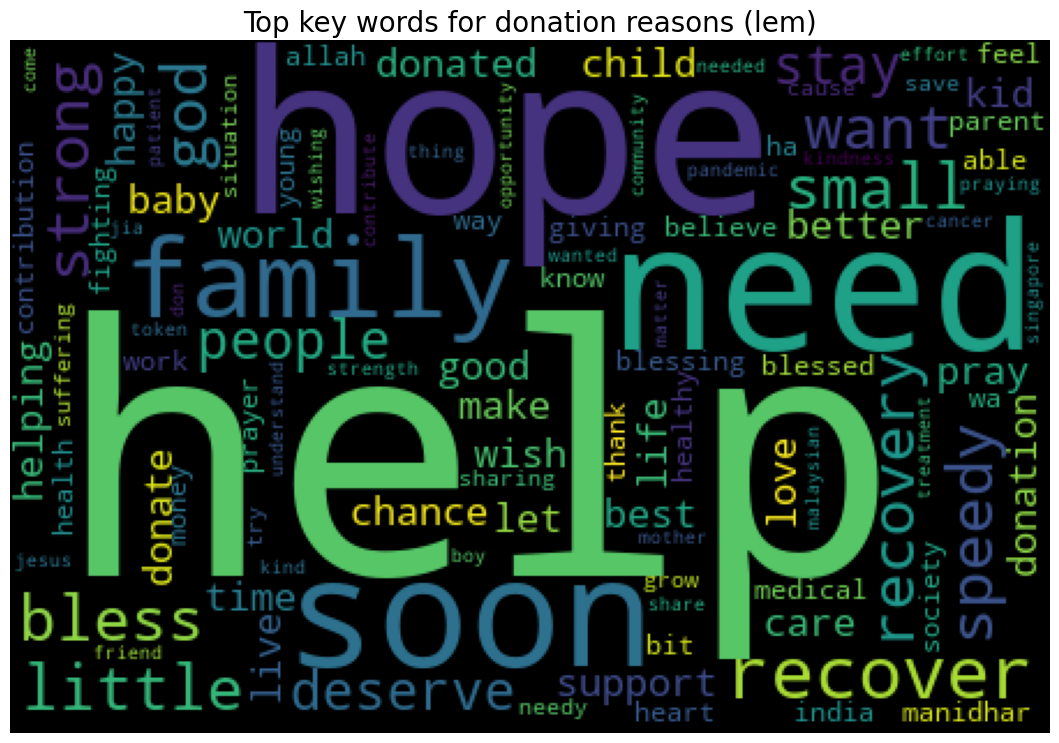

In [74]:
text = WordCloud(width=450,height= 300).generate(' '.join(lem_ngram['unigram/bigram']))
plt.figure(figsize=(19,9))
plt.axis('off')
plt.title("Top key words for donation reasons (lem)",fontsize=20)
plt.imshow(text)
plt.show()

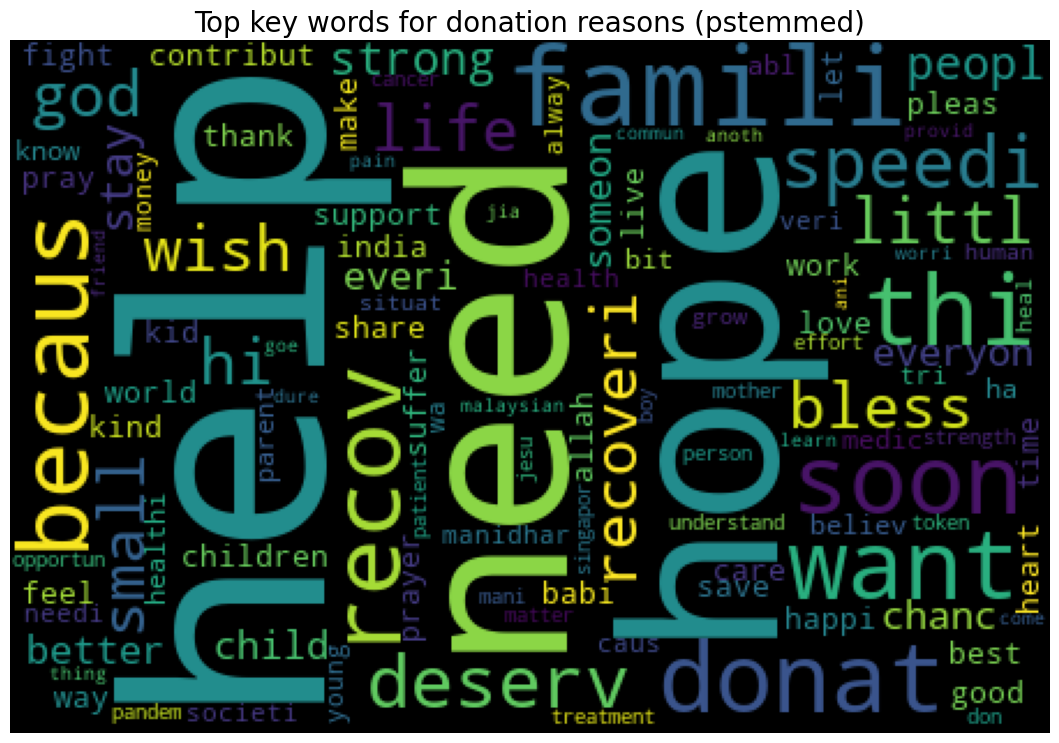

In [75]:
text = WordCloud(width=450,height= 300).generate(' '.join(pstem_ngram['unigram/bigram']))
plt.figure(figsize=(19,9))
plt.axis('off')
plt.title("Top key words for donation reasons (pstemmed)",fontsize=20)
plt.imshow(text)
plt.show()

#### ii. TF-IDF with lemmatized and porter-stemmed cleaned data

In [76]:
tvec = TfidfVectorizer(stop_words = 'english',
                     ngram_range = (1,2),
                     min_df = 0.01,
                     max_df = 0.9,)

In [77]:
tvec.fit(lem_vec)

#matrix of n-grams
ngrams_lem_tvec = tvec.fit_transform(lem_vec)

#count frequency of n-grams
count_freq = ngrams_lem_tvec.toarray().sum(axis=0)

#list of n-grams
vocab = tvec.vocabulary_

lem_tvec_ngram = pd.DataFrame(sorted([(count_freq[i],k) for k, i in vocab.items()], reverse=True)).rename(columns={0: 'frequency', 1:'unigram/bigram'})

In [78]:
lem_tvec_ngram.head(20)

,frequency,unigram/bigram
0,78.509734,help
1,53.583180,hope
2,51.720526,soon
3,33.356983,need
4,33.081612,family
5,32.228627,donated
6,27.478158,life
7,25.584976,want
8,25.461297,recovery
9,24.930778,child


In [79]:
lem_tvec_ngram.tail(20)

,frequency,unigram/bigram
103,5.735842,strength
104,5.728586,hope small
105,5.689021,situation
106,5.642067,opportunity
107,5.634499,mother
108,5.617422,effort
109,5.613409,thing
110,5.606869,community
111,5.151316,malaysian
112,5.123000,boy


In [80]:
tvec.fit(pstem_vec)

#matrix of n-grams
ngrams_pstem_tvec = tvec.fit_transform(pstem_vec)

#count frequency of n-grams
count_freq = ngrams_pstem_tvec.toarray().sum(axis=0)

#list of n-grams
vocab = tvec.vocabulary_

pstem_tvec_ngram = pd.DataFrame(sorted([(count_freq[i],k) for k, i in vocab.items()], reverse=True)).rename(columns={0: 'frequency', 1:'unigram/bigram'})

In [81]:
pstem_tvec_ngram.head(20)

,frequency,unigram/bigram
0,79.466247,help
1,52.992936,hope
2,47.873508,soon
3,38.575928,donat
4,35.547317,need
5,31.605794,becaus
6,31.368539,thi
7,30.038560,bless
8,29.131494,famili
9,27.225438,want


In [82]:
pstem_tvec_ngram.tail(20)

,frequency,unigram/bigram
121,4.799977,deserv chanc
122,4.799042,cancer
123,4.797951,malaysian
124,4.772749,opportun
125,4.733805,boy
126,4.732500,goe
127,4.656785,friend
128,4.515000,provid
129,4.402601,wish speedi
130,4.401854,ani


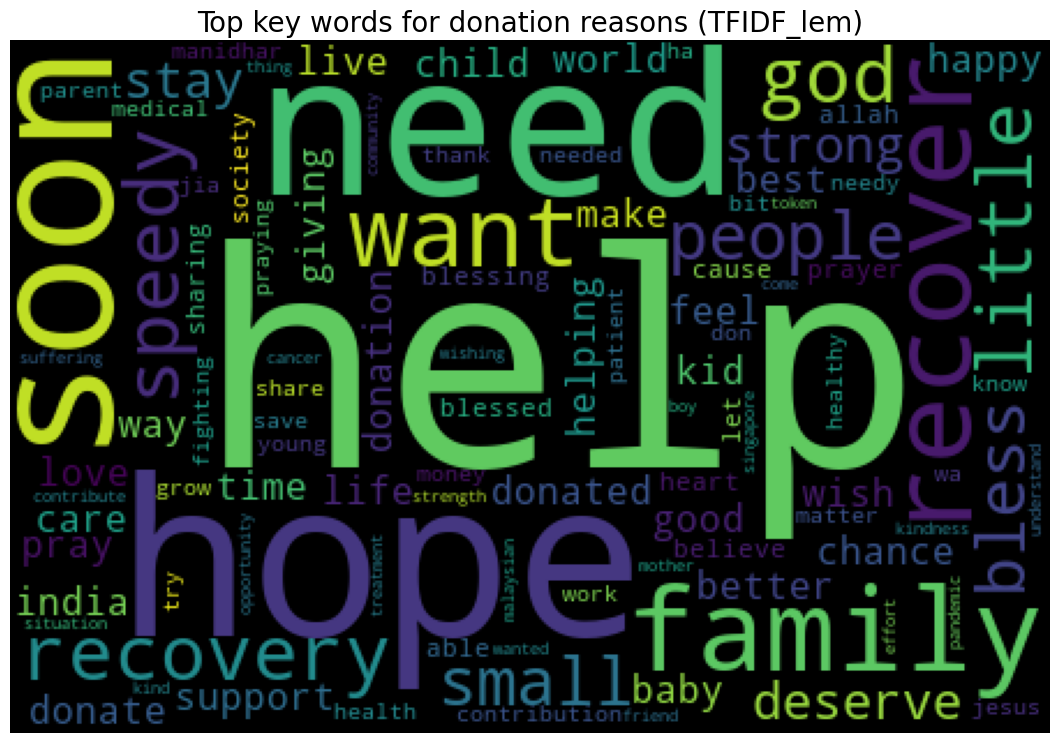

In [83]:
text = WordCloud(width=450,height= 300).generate(' '.join(lem_tvec_ngram['unigram/bigram']))
plt.figure(figsize=(19,9))
plt.axis('off')
plt.title("Top key words for donation reasons (TFIDF_lem)",fontsize=20)
plt.imshow(text)
plt.show()

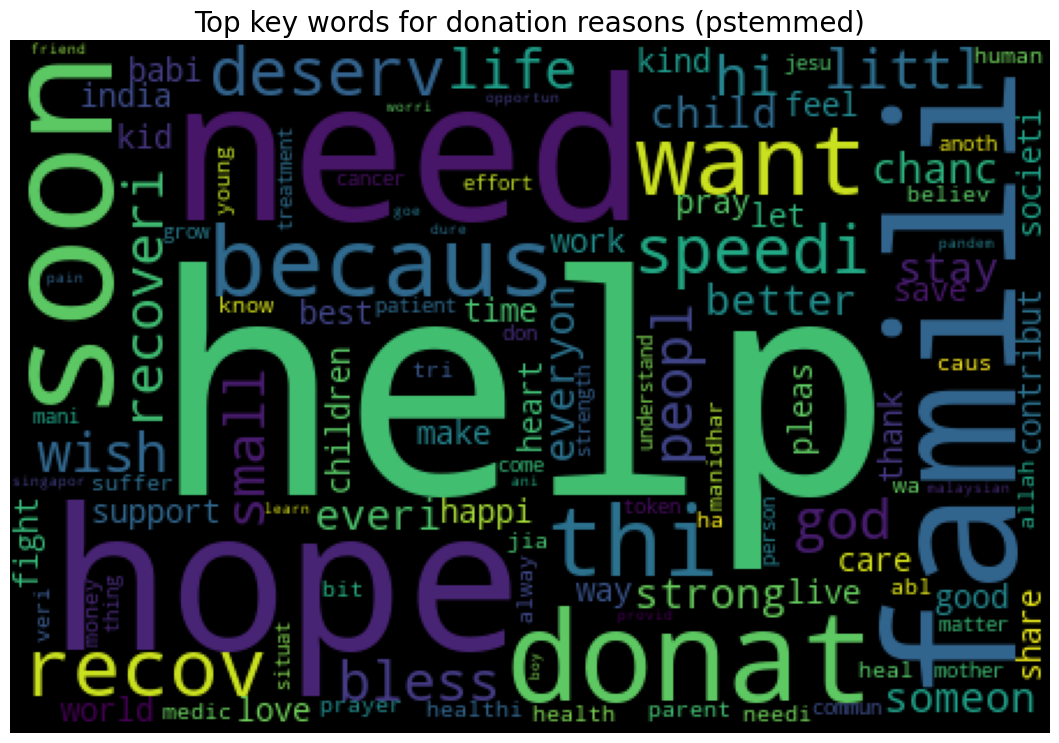

In [84]:
text = WordCloud(width=450,height= 300).generate(' '.join(pstem_tvec_ngram['unigram/bigram']))
plt.figure(figsize=(19,9))
plt.axis('off')
plt.title("Top key words for donation reasons (pstemmed)",fontsize=20)
plt.imshow(text)
plt.show()

In [85]:
#cvec and tfidf dataframe for lemmatized data
frames_lem = [lem_tvec_ngram, lem_ngram]

In [86]:
#concat
lem_df = pd.concat(frames_lem, axis = 1, join = 'outer')
lem_df

,frequency,unigram/bigram,frequency,unigram/bigram
0,78.509734,help,255,help
1,53.583180,hope,161,hope
2,51.720526,soon,105,soon
3,33.356983,need,93,family
4,33.081612,family,90,need
5,32.228627,donated,88,donated
6,27.478158,life,71,life
7,25.584976,want,67,god
8,25.461297,recovery,63,recovery
9,24.930778,child,62,want


In [87]:
#cvec and tfidf dataframe for porter-stemmed data
frames_pstem = [pstem_tvec_ngram, pstem_ngram]

In [88]:
#concat
pstem_df = pd.concat(frames_pstem, axis = 1, join = 'outer')
pstem_df

,frequency,unigram/bigram,frequency,unigram/bigram
0,79.466247,help,285,help
1,52.992936,hope,178,hope
2,47.873508,soon,139,donat
3,38.575928,donat,118,thi
4,35.547317,need,108,becaus
5,31.605794,becaus,105,soon
6,31.368539,thi,102,need
7,30.038560,bless,93,famili
8,29.131494,famili,88,bless
9,27.225438,want,82,donat becaus


**Observations**

- Based on the two dataframes, lemmatized dataframes have lesser rows (122) compared to porter-stemmed dataframes (140). 
- For language based text clustering, it would be easier to analyze with lemmatized data as lemmatizing is usually the more precise way of handling words from grammatical standpoint.
- 'help' is a high frequency word that appears in both dataframes. We would proceed to remove these high frequency words to see if it would improve on the clustering. 
- stopwords list to include words like 'help', 'hope', 'donated', 'just', 'let', 'ha', 'wa', 'don', 'donate', 'donation', 'soon'
- Will proceed clustering algorithms with lemmatized data, using both CountVectorizer and TF-IDF to compare the results. 


### Types of clustering algorithms

There are different types of clustering algorithms that handle all kinds of unique data. 


#### Centroid - based 

K-means clustering is the most commonly used clustering algorithm. It is a centroid- based algorithm and the simplest unsupervised learning algorithm. Centroid-based clustering is a little sensitive to the initial parameters you give it, but it's fast and efficient.

These types of algorithms separate data points based on multiple centroids in the data. Each data point is assigned to a cluster based on its squared distance from the centroid. This is the most commonly used type of clustering. 

#### Density - based

Density Based Spatial Clustering of Applications with Noise (DBSCAN) is density-based unsupervised clustering algorithm. In density-based clustering, data is grouped by areas of high concentrations of data points surrounded by areas of low concentrations of data points. Basically the algorithm finds the places that are dense with data points and calls those clusters. It is good for data which contains clusters of similar density. 

The great thing about this is that the clusters can be any shape. You aren't constrained to expected conditions.

The clustering algorithms under this type don't try to assign outliers to clusters, so they get ignored. 


#### Graph - based 

Affinity propagation is based on the concept of 'message passing' between data points. Each data point sends messages to all other points informing its targets of each target's relative attractiveness to the sender. Unlike clustering algorithms such as k-means, affinity propagation does not require the number of clusters to be determined or estimated before running the algorithm. 


For this particular project, we will explore these 3 different types of clustering algorithms - **K-means clustering algorithm**,  **DBSCAN** and **Affinity Propagation**.

### K-means clustering algorithm

**With TfidfVectorizer**

In [89]:
#tfidfvectorizer with lemmatized text

#Remove general stopwords in english language
#instantiate tfidf

add_stop = ['help', 'hope', 'donated', 'just', 'let', 'ha', 'wa', 'don', 'donate', 'donation', 'soon']
stoplist = stopwords.words('english') + add_stop

vec = TfidfVectorizer(stop_words = stoplist,
                     ngram_range = (1,2),
                     min_df = 0.01,
                     max_df = 0.8,)

In [90]:
X = vec.fit_transform(lem_vec)

In [91]:
X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [92]:
#initialize kmeans with 4 centroids
kmeans = KMeans(n_clusters = 4, random_state = 42)

In [93]:
#fit the model
kmeans.fit(X)

KMeans(n_clusters=4, random_state=42)

In [94]:
#store cluster labels in a variable
clusters = kmeans.labels_

In [95]:
[c for c in clusters][:10]

[0, 1, 0, 0, 0, 0, 2, 1, 0, 2]

In [96]:
#initialize PCA with 2 components
pca = PCA(n_components = 2, random_state = 42)

#pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(X.toarray())

#save our two dimensions into x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

In [97]:
#organize dataframe by creating columns cluster, x0, x1

df['cluster'] = clusters
df['x0'] = x0
df['x1'] = x1

In [98]:
def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(X.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vec.get_feature_names_out() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(15)


Cluster 0
small,others,care,good,god,baby,support,love,child,give,little,life,recover,want,family

Cluster 1
always,deserves,everyone,boy,young,god,stay strong,stay,please,manidhar,strong,wish,get,get well,well

Cluster 2
small,better,always,medical,others,india,pandemic,support,life,someone,family need,family,want,people,need

Cluster 3
little,may,wishing,medical,praying,family,pray,god bless,bless,god,recover,wish,speedy recovery,recovery,speedy


In [99]:
df[df['cluster']==0].head()

,comment,currency,amount,text_length,text_wordcount,tokenized_comment,token_lem,token_pstem,cleaned_lem,cleaned_pstem,cluster,x0,x1
0,"Imagine you are Joceline’s parent, you’ll defi...",MYR,50000,178.0,29.0,"[imagine, you, are, joceline, s, parent, you, ...","[imagine, you, are, joceline, s, parent, you, ...","[imagin, you, are, jocelin, s, parent, you, ll...",imagine you are joceline s parent you ll defin...,imagin you are jocelin s parent you ll definit...,0,0.184352,0.059229
2,"Everyone, please donate any amount that you ca...",SGD,5000,77.0,13.0,"[everyone, please, donate, any, amount, that, ...","[everyone, please, donate, any, amount, that, ...","[everyon, pleas, donat, ani, amount, that, you...",everyone please donate any amount that you can...,everyon pleas donat ani amount that you can ev...,0,-0.037918,-0.054536
3,This breaks my heart seeing a young baby like ...,SGD,1000,211.0,45.0,"[this, breaks, my, heart, seeing, a, young, ba...","[this, break, my, heart, seeing, a, young, bab...","[thi, break, my, heart, see, a, young, babi, l...",this break my heart seeing a young baby like t...,thi break my heart see a young babi like thi a...,0,-0.067497,-0.030065
4,My baby is 1 month younger then Niyaz. And I c...,SGD,5000,163.0,31.0,"[my, baby, is, month, younger, then, niyaz, an...","[my, baby, is, month, younger, then, niyaz, an...","[my, babi, is, month, younger, then, niyaz, an...",my baby is month younger then niyaz and i cann...,my babi is month younger then niyaz and i cann...,0,-0.070294,-0.026580
5,Because it is the right thing to do.,SGD,50000,36.0,8.0,"[because, it, is, the, right, thing, to, do]","[because, it, is, the, right, thing, to, do]","[becaus, it, is, the, right, thing, to, do]",because it is the right thing to do,becaus it is the right thing to do,0,-0.040815,-0.028937


In [100]:
df[df['cluster']==1].head()

,comment,currency,amount,text_length,text_wordcount,tokenized_comment,token_lem,token_pstem,cleaned_lem,cleaned_pstem,cluster,x0,x1
1,My prayers will always be with you sayang ❤.. ...,SGD,2000,74.0,14.0,"[my, prayers, will, always, be, with, you, say...","[my, prayer, will, always, be, with, you, saya...","[my, prayer, will, alway, be, with, you, sayan...",my prayer will always be with you sayang stay ...,my prayer will alway be with you sayang stay s...,1,0.484756,-0.006699
7,My prayers will always be with you. Stay stron...,SGD,2000,64.0,13.0,"[my, prayers, will, always, be, with, you, sta...","[my, prayer, will, always, be, with, you, stay...","[my, prayer, will, alway, be, with, you, stay,...",my prayer will always be with you stay strong ...,my prayer will alway be with you stay strong g...,1,0.484756,-0.006699
42,A lack of generosity refuses to acknowledge th...,SGD,10000,145.0,27.0,"[a, lack, of, generosity, refuses, to, acknowl...","[a, lack, of, generosity, refuse, to, acknowle...","[a, lack, of, generos, refus, to, acknowledg, ...",a lack of generosity refuse to acknowledge tha...,a lack of generos refus to acknowledg that you...,1,0.635651,0.015500
58,Be strong! Get well soon,SGD,10000,24.0,5.0,"[be, strong, get, well, soon]","[be, strong, get, well, soon]","[be, strong, get, well, soon]",be strong get well soon,be strong get well soon,1,0.796681,0.006349
61,I hope she'll get well soon ♡,MYR,1000,29.0,7.0,"[i, hope, she, ll, get, well, soon]","[i, hope, she, ll, get, well, soon]","[i, hope, she, ll, get, well, soon]",i hope she ll get well soon,i hope she ll get well soon,1,0.932562,-0.000222


In [101]:
df[df['cluster']==2].head()

,comment,currency,amount,text_length,text_wordcount,tokenized_comment,token_lem,token_pstem,cleaned_lem,cleaned_pstem,cluster,x0,x1
6,I donated because I hope this small amount hel...,SGD,5000,106.0,19.0,"[i, donated, because, i, hope, this, small, am...","[i, donated, because, i, hope, this, small, am...","[i, donat, becaus, i, hope, thi, small, amount...",i donated because i hope this small amount hel...,i donat becaus i hope thi small amount help th...,2,-0.101631,-0.103837
9,I just wanna help people to get a better life ...,VND,250000,159.0,29.0,"[i, just, wanna, help, people, to, get, a, bet...","[i, just, wanna, help, people, to, get, a, bet...","[i, just, wanna, help, peopl, to, get, a, bett...",i just wanna help people to get a better life ...,i just wanna help peopl to get a better life n...,2,0.165496,-0.128772
10,"Sharing is caring, hope everything will be fin...",SGD,5000,67.0,11.0,"[sharing, is, caring, hope, everything, will, ...","[sharing, is, caring, hope, everything, will, ...","[share, is, care, hope, everyth, will, be, fin...",sharing is caring hope everything will be fine...,share is care hope everyth will be fine for my...,2,-0.075864,-0.090570
13,Kids on the spectrum need acceptance and the s...,SGD,10000,223.0,36.0,"[kids, on, the, spectrum, need, acceptance, an...","[kid, on, the, spectrum, need, acceptance, and...","[kid, on, the, spectrum, need, accept, and, th...",kid on the spectrum need acceptance and the so...,kid on the spectrum need accept and the societ...,2,-0.074407,-0.106913
38,I want to help this baby in dire need on his h...,SGD,25000,61.0,13.0,"[i, want, to, help, this, baby, in, dire, need...","[i, want, to, help, this, baby, in, dire, need...","[i, want, to, help, thi, babi, in, dire, need,...",i want to help this baby in dire need on his h...,i want to help thi babi in dire need on hi hea...,2,-0.122349,-0.220821


In [102]:
df[df['cluster']==3].head()

,comment,currency,amount,text_length,text_wordcount,tokenized_comment,token_lem,token_pstem,cleaned_lem,cleaned_pstem,cluster,x0,x1
54,I can understand how Mila feel helpless with s...,SGD,20000,86.0,14.0,"[i, can, understand, how, mila, feel, helpless...","[i, can, understand, how, mila, feel, helpless...","[i, can, understand, how, mila, feel, helpless...",i can understand how mila feel helpless with s...,i can understand how mila feel helpless with s...,3,-0.104881,0.577981
76,"May god shower his blessings to Mani,speedy re...",SGD,5000,65.0,11.0,"[may, god, shower, his, blessings, to, mani, s...","[may, god, shower, his, blessing, to, mani, sp...","[may, god, shower, hi, bless, to, mani, speedi...",may god shower his blessing to mani speedy rec...,may god shower hi bless to mani speedi recover...,3,-0.114407,0.539962
125,and prayers for your complete recovery...,SGD,5000,41.0,6.0,"[and, prayers, for, your, complete, recovery]","[and, prayer, for, your, complete, recovery]","[and, prayer, for, your, complet, recoveri]",and prayer for your complete recovery,and prayer for your complet recoveri,3,-0.069276,0.296370
162,Be a small part in making sure Manidhar recove...,SGD,10800,101.0,19.0,"[be, a, small, part, in, making, sure, manidha...","[be, a, small, part, in, making, sure, manidha...","[be, a, small, part, in, make, sure, manidhar,...",be a small part in making sure manidhar recove...,be a small part in make sure manidhar recov an...,3,0.376121,0.461507
175,Wishing Mdm Ng a speedy recovery and able to s...,SGD,5000,76.0,15.0,"[wishing, mdm, ng, a, speedy, recovery, and, a...","[wishing, mdm, ng, a, speedy, recovery, and, a...","[wish, mdm, ng, a, speedi, recoveri, and, abl,...",wishing mdm ng a speedy recovery and able to s...,wish mdm ng a speedi recoveri and abl to see h...,3,-0.116587,0.488918


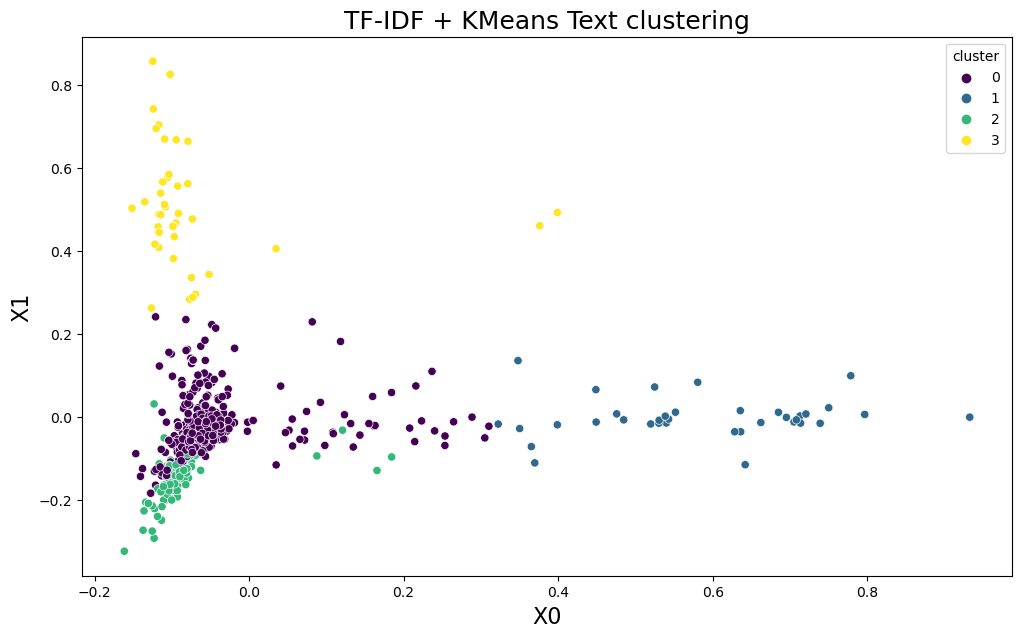

In [103]:
# set image size
plt.figure(figsize=(12, 7))
# set a title
plt.title("TF-IDF + KMeans Text clustering", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df, x='x0', y='x1', hue='cluster', palette="viridis")
plt.show()

In [104]:
silhouette_score(X, labels = kmeans.predict(X))

0.07743980531963804

**Observations:**

- Looks like there are alot of overlapping between the clusters.
- From the top 15 words from each clusters, there are several repeated words in each clusters.
- We can aim to improve on the stop words to see if it improves the silhouette score. 


In [105]:
#to find the mysterious k in k-means
#we can try the elbow method

sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters = k)
    km = km.fit(X)
    sum_of_squared_distances.append(km.inertia_)

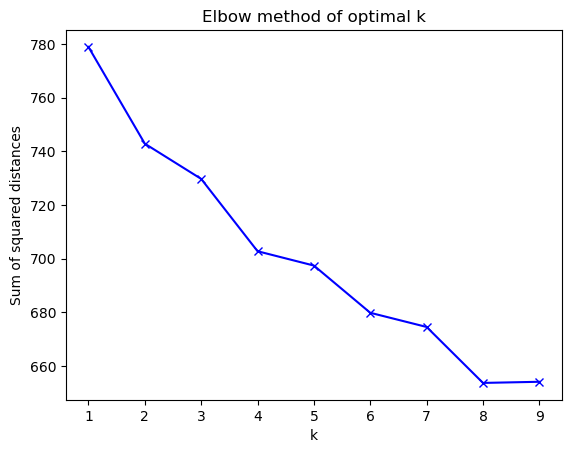

In [106]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow method of optimal k')
plt.show()

The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a,b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of.

The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar. Do note that a high score does not necessarily indicate good clustering. Instead, it measures at best the difference between the metric and what our clustering algorithm opitmized for. 

This value means that our clusters are overlapping. We can also see this in the plot above. Perhaps tuning different parameters for feature extractor and the clustering model will increase this score. 

In [107]:
#alternative way to calculate k in kmeans 
#we can try the silhouette method

sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(X)
  labels = kmeans.labels_
  sil.append(silhouette_score(X, labels, metric = 'euclidean'))

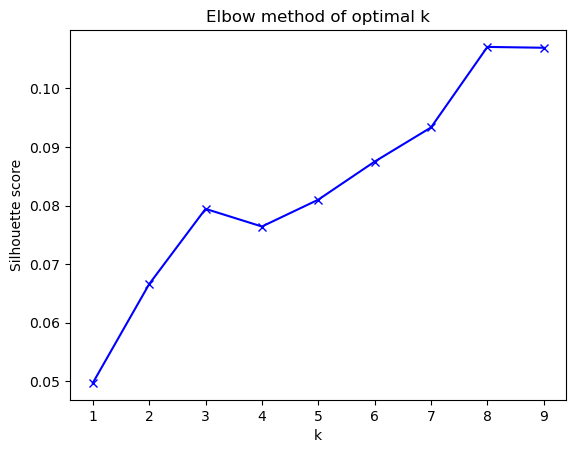

In [108]:
plt.plot(K, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Elbow method of optimal k')
plt.show()

**Observations:**

- If we keep the number of clusters below 5, the highest performing number of clusters would be at 4. 
- Previously, we experimented with other cluster numbers, but the clustering is not meaningful for post analysis. 

### K-Means Clustering Algorithm #2

**With CountfVectorizer**

In [109]:
#Countvectorizer

#Remove general stopwords in english language

#add_stop = ['help']
add_stop = ['help', 'hope', 'donated', 'just', 'let', 'ha', 'wa', 'don', 'donate', 'donation', 'soon']
stoplist = stopwords.words('english') + add_stop

cvec = CountVectorizer(stop_words = stoplist,
                     ngram_range = (1,2),
                     min_df = 0.01,
                     max_df = 0.8,)

In [110]:
X1 = cvec.fit_transform(lem_vec)

In [111]:
#initialize kmeans with 4 centroids
kmeans = KMeans(n_clusters = 4, random_state = 42)
#fit the model
kmeans.fit(X1)
#store cluster labels in a variable
clusters1 = kmeans.labels_

In [112]:
[c for c in clusters1][:10]

[2, 2, 3, 1, 3, 3, 3, 2, 3, 1]

In [113]:
#initialize PCA with 2 components
pca = PCA(n_components = 2, random_state = 42)

#pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(X1.toarray())

#save our two dimensions into x0 and x1
x0_1 = pca_vecs[:, 0]
x1_1 = pca_vecs[:, 1]

In [114]:
#organize dataframe by creating columns cluster, x0, x1

df['cluster1'] = clusters
df['x0_1'] = x0_1
df['x1_1'] = x1_1

In [115]:
def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(X1.todense()).groupby(clusters1).mean() # groups the TF-IDF vector by cluster
    terms = vec.get_feature_names_out() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(15)


Cluster 0
others,recover,child,blessing,pray,love,speedy recovery,may god,speedy,recovery,family,may,god bless,bless,god

Cluster 1
make,may,stay strong,deserves,small,family,strong,stay,world,little,chance,better,one,child,life

Cluster 2
god,wish,young,boy,better,need,pray,stay strong,manidhar,see,stay,strong,well,get well,get

Cluster 3
love,little,speedy recovery,wish,baby,people,small,recover,speedy,support,give,recovery,want,family,need


In [116]:
df[df['cluster1']==0].head()

,comment,currency,amount,text_length,text_wordcount,tokenized_comment,token_lem,token_pstem,cleaned_lem,cleaned_pstem,cluster,x0,x1,cluster1,x0_1,x1_1
0,"Imagine you are Joceline’s parent, you’ll defi...",MYR,50000,178.0,29.0,"[imagine, you, are, joceline, s, parent, you, ...","[imagine, you, are, joceline, s, parent, you, ...","[imagin, you, are, jocelin, s, parent, you, ll...",imagine you are joceline s parent you ll defin...,imagin you are jocelin s parent you ll definit...,0,0.184352,0.059229,0,1.202714,0.329506
2,"Everyone, please donate any amount that you ca...",SGD,5000,77.0,13.0,"[everyone, please, donate, any, amount, that, ...","[everyone, please, donate, any, amount, that, ...","[everyon, pleas, donat, ani, amount, that, you...",everyone please donate any amount that you can...,everyon pleas donat ani amount that you can ev...,0,-0.037918,-0.054536,0,-0.133693,-0.230396
3,This breaks my heart seeing a young baby like ...,SGD,1000,211.0,45.0,"[this, breaks, my, heart, seeing, a, young, ba...","[this, break, my, heart, seeing, a, young, bab...","[thi, break, my, heart, see, a, young, babi, l...",this break my heart seeing a young baby like t...,thi break my heart see a young babi like thi a...,0,-0.067497,-0.030065,0,-0.151583,0.133517
4,My baby is 1 month younger then Niyaz. And I c...,SGD,5000,163.0,31.0,"[my, baby, is, month, younger, then, niyaz, an...","[my, baby, is, month, younger, then, niyaz, an...","[my, babi, is, month, younger, then, niyaz, an...",my baby is month younger then niyaz and i cann...,my babi is month younger then niyaz and i cann...,0,-0.070294,-0.026580,0,-0.216513,0.305490
5,Because it is the right thing to do.,SGD,50000,36.0,8.0,"[because, it, is, the, right, thing, to, do]","[because, it, is, the, right, thing, to, do]","[becaus, it, is, the, right, thing, to, do]",because it is the right thing to do,becaus it is the right thing to do,0,-0.040815,-0.028937,0,-0.113616,-0.208632


In [117]:
df[df['cluster1']==1].head()

,comment,currency,amount,text_length,text_wordcount,tokenized_comment,token_lem,token_pstem,cleaned_lem,cleaned_pstem,cluster,x0,x1,cluster1,x0_1,x1_1
1,My prayers will always be with you sayang ❤.. ...,SGD,2000,74.0,14.0,"[my, prayers, will, always, be, with, you, say...","[my, prayer, will, always, be, with, you, saya...","[my, prayer, will, alway, be, with, you, sayan...",my prayer will always be with you sayang stay ...,my prayer will alway be with you sayang stay s...,1,0.484756,-0.006699,1,1.889704,0.207167
7,My prayers will always be with you. Stay stron...,SGD,2000,64.0,13.0,"[my, prayers, will, always, be, with, you, sta...","[my, prayer, will, always, be, with, you, stay...","[my, prayer, will, alway, be, with, you, stay,...",my prayer will always be with you stay strong ...,my prayer will alway be with you stay strong g...,1,0.484756,-0.006699,1,1.889704,0.207167
42,A lack of generosity refuses to acknowledge th...,SGD,10000,145.0,27.0,"[a, lack, of, generosity, refuses, to, acknowl...","[a, lack, of, generosity, refuse, to, acknowle...","[a, lack, of, generos, refus, to, acknowledg, ...",a lack of generosity refuse to acknowledge tha...,a lack of generos refus to acknowledg that you...,1,0.635651,0.015500,1,1.482155,0.295256
58,Be strong! Get well soon,SGD,10000,24.0,5.0,"[be, strong, get, well, soon]","[be, strong, get, well, soon]","[be, strong, get, well, soon]",be strong get well soon,be strong get well soon,1,0.796681,0.006349,1,1.660703,0.050422
61,I hope she'll get well soon ♡,MYR,1000,29.0,7.0,"[i, hope, she, ll, get, well, soon]","[i, hope, she, ll, get, well, soon]","[i, hope, she, ll, get, well, soon]",i hope she ll get well soon,i hope she ll get well soon,1,0.932562,-0.000222,1,1.521388,-0.034700


In [118]:
df[df['cluster1']==2].head()

,comment,currency,amount,text_length,text_wordcount,tokenized_comment,token_lem,token_pstem,cleaned_lem,cleaned_pstem,cluster,x0,x1,cluster1,x0_1,x1_1
6,I donated because I hope this small amount hel...,SGD,5000,106.0,19.0,"[i, donated, because, i, hope, this, small, am...","[i, donated, because, i, hope, this, small, am...","[i, donat, becaus, i, hope, thi, small, amount...",i donated because i hope this small amount hel...,i donat becaus i hope thi small amount help th...,2,-0.101631,-0.103837,2,-0.296417,0.081261
9,I just wanna help people to get a better life ...,VND,250000,159.0,29.0,"[i, just, wanna, help, people, to, get, a, bet...","[i, just, wanna, help, people, to, get, a, bet...","[i, just, wanna, help, peopl, to, get, a, bett...",i just wanna help people to get a better life ...,i just wanna help peopl to get a better life n...,2,0.165496,-0.128772,2,0.461025,-0.242844
10,"Sharing is caring, hope everything will be fin...",SGD,5000,67.0,11.0,"[sharing, is, caring, hope, everything, will, ...","[sharing, is, caring, hope, everything, will, ...","[share, is, care, hope, everyth, will, be, fin...",sharing is caring hope everything will be fine...,share is care hope everyth will be fine for my...,2,-0.075864,-0.090570,2,-0.160391,-0.256224
13,Kids on the spectrum need acceptance and the s...,SGD,10000,223.0,36.0,"[kids, on, the, spectrum, need, acceptance, an...","[kid, on, the, spectrum, need, acceptance, and...","[kid, on, the, spectrum, need, accept, and, th...",kid on the spectrum need acceptance and the so...,kid on the spectrum need accept and the societ...,2,-0.074407,-0.106913,2,-0.186685,-0.273280
38,I want to help this baby in dire need on his h...,SGD,25000,61.0,13.0,"[i, want, to, help, this, baby, in, dire, need...","[i, want, to, help, this, baby, in, dire, need...","[i, want, to, help, thi, babi, in, dire, need,...",i want to help this baby in dire need on his h...,i want to help thi babi in dire need on hi hea...,2,-0.122349,-0.220821,2,-0.225248,-0.264298


In [119]:
df[df['cluster1']==3].head()

,comment,currency,amount,text_length,text_wordcount,tokenized_comment,token_lem,token_pstem,cleaned_lem,cleaned_pstem,cluster,x0,x1,cluster1,x0_1,x1_1
54,I can understand how Mila feel helpless with s...,SGD,20000,86.0,14.0,"[i, can, understand, how, mila, feel, helpless...","[i, can, understand, how, mila, feel, helpless...","[i, can, understand, how, mila, feel, helpless...",i can understand how mila feel helpless with s...,i can understand how mila feel helpless with s...,3,-0.104881,0.577981,3,-0.322966,1.048893
76,"May god shower his blessings to Mani,speedy re...",SGD,5000,65.0,11.0,"[may, god, shower, his, blessings, to, mani, s...","[may, god, shower, his, blessing, to, mani, sp...","[may, god, shower, hi, bless, to, mani, speedi...",may god shower his blessing to mani speedy rec...,may god shower hi bless to mani speedi recover...,3,-0.114407,0.539962,3,-0.415976,1.659154
125,and prayers for your complete recovery...,SGD,5000,41.0,6.0,"[and, prayers, for, your, complete, recovery]","[and, prayer, for, your, complete, recovery]","[and, prayer, for, your, complet, recoveri]",and prayer for your complete recovery,and prayer for your complet recoveri,3,-0.069276,0.296370,3,-0.169783,0.293010
162,Be a small part in making sure Manidhar recove...,SGD,10800,101.0,19.0,"[be, a, small, part, in, making, sure, manidha...","[be, a, small, part, in, making, sure, manidha...","[be, a, small, part, in, make, sure, manidhar,...",be a small part in making sure manidhar recove...,be a small part in make sure manidhar recov an...,3,0.376121,0.461507,3,1.350748,1.408879
175,Wishing Mdm Ng a speedy recovery and able to s...,SGD,5000,76.0,15.0,"[wishing, mdm, ng, a, speedy, recovery, and, a...","[wishing, mdm, ng, a, speedy, recovery, and, a...","[wish, mdm, ng, a, speedi, recoveri, and, abl,...",wishing mdm ng a speedy recovery and able to s...,wish mdm ng a speedi recoveri and abl to see h...,3,-0.116587,0.488918,3,-0.475422,2.257487


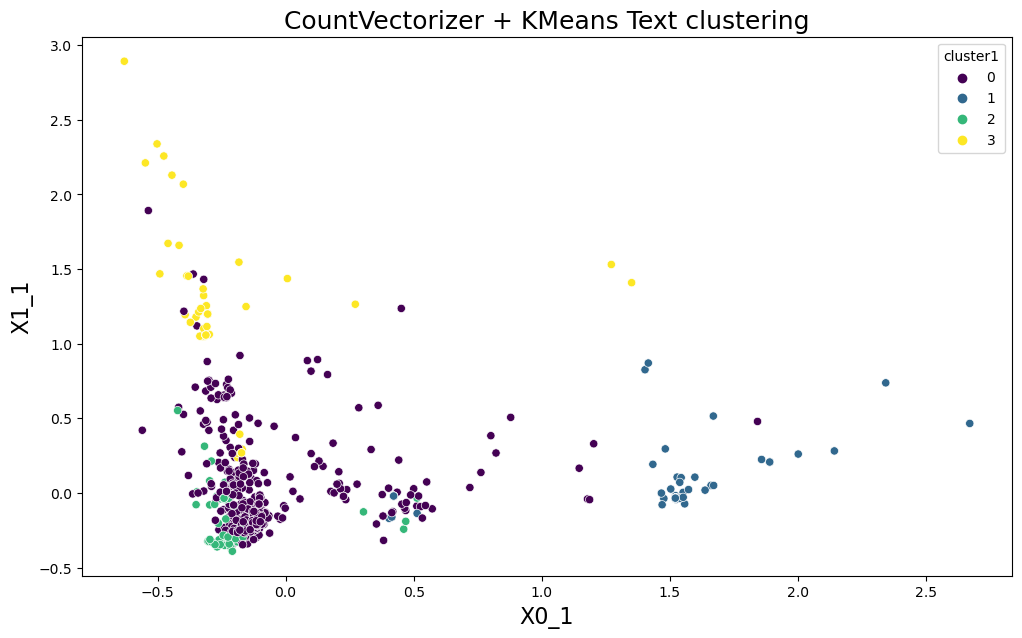

In [120]:
# set image size
plt.figure(figsize=(12, 7))
# set a title
plt.title("CountVectorizer + KMeans Text clustering", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0_1", fontdict={"fontsize": 16})
plt.ylabel("X1_1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df, x='x0_1', y='x1_1', hue='cluster1', palette="viridis")
plt.show()

In [121]:
silhouette_score(X1, labels = kmeans.predict(X1))

0.1585284503673602

In [122]:
sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters = k)
    km = km.fit(X1)
    sum_of_squared_distances.append(km.inertia_)

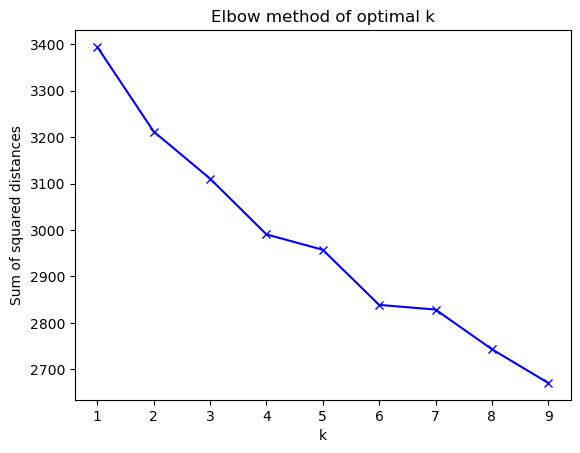

In [123]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow method of optimal k')
plt.show()

In [124]:
#alternative way to calculate k in kmeans 
#we can try the silhouette method

sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(X1)
  labels = kmeans.labels_
  sil.append(silhouette_score(X1, labels, metric = 'euclidean'))

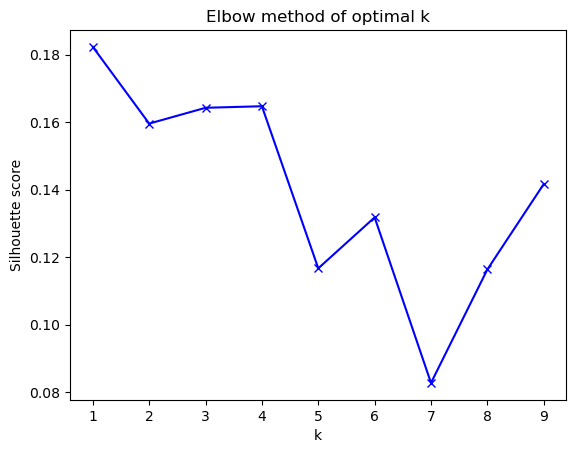

In [125]:
plt.plot(K, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Elbow method of optimal k')
plt.show()

**Observations:**

- The silhouette score for k = 4 is the highest when compared to TF-IDF. 
- The top words appearing in Cluster 0, clearly overlaps with Cluster 2. 
- Cluster 1 and Cluster 3 are pretty distinctive. 
- We can proceed to use CountVectorizer with KMeans = 4 for our evaluation. 

### DBSCAN Clustering Algorithm with Counvectorizer

#### Steps involved in DBSCAN clustering algorithm
1. Choose any point p randomly 
2. Identify all density reachable points from *p* with ε and min_samples parameter
3. If *p* is a core point, create a cluster with (ε and min_samples)
4. If *p* is a border point, visit the next point in a dataset
5. Continue the algorithm until all points are visited

To determine the optimal ε parameter, I will compute the k-nearest neighbor (KNN) distances (average distance of every data point to its k-nearest neighbors)  of an input dataset using k-nearest neighbor method (unsupervised nearest neighbors learning). For finding the k-nearest neighbor, I will use the sklearn.neighbors.NearestNeighbors function.

NearestNeighbors function requires *n_neighbors* (number of neighbors) parameter, which can be same as *min_samples* value. 

#### Finding the Optimal Value of Epsilon

Rather than experimenting with different values of epsilon, we can use the elbow point detection method to arrive at a suitable value of epsilon. 

In [126]:
#n_neighbors = 4 as kneighbors function returns distance of point to itself 
#(i.e. first column will be zeros) 
nbrs = NearestNeighbors(n_neighbors=4).fit(X1)

#find the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(X1)
neigh_dist = np.sort(neigh_dist[:,3], axis = 0)

#sort the neighbor distances (lengths to points) in ascending order
#axis = 0 represents sort along first axis i.e. sort along row
#sort_neigh_dist = np.sort(neigh_dist, axis=0)

Text(0, 0.5, 'Distance')

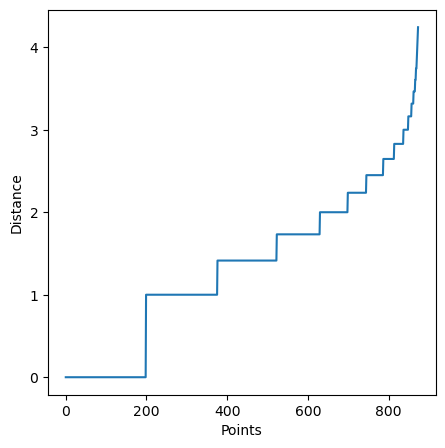

In [127]:
fig = plt.figure(figsize=(5, 5))
plt.plot(neigh_dist)
plt.xlabel("Points")
plt.ylabel("Distance")

#### Identifying Elbow Point with Kneed Package

To determine the location of maximum curvature visually can be difficult. Hence a Python package called kneed can be used to detect the knee or elbow point. This can be installed with 'pip install kneed'.

2.449489742783178


<Figure size 500x500 with 0 Axes>

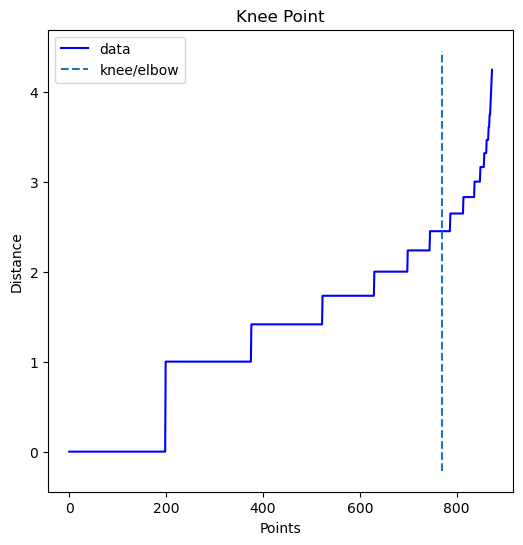

In [128]:
i = np.arange(len(neigh_dist))
knee = KneeLocator(i, neigh_dist, S=1, curve='convex', direction='increasing', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print(neigh_dist[knee.knee])

#### Applying DBSCAN with Optimal value of Epsilon = 2.449

In [129]:
dbscan_cluster = DBSCAN(eps=2.449, min_samples=5)
dbscan_cluster.fit(X1)

DBSCAN(eps=2.449)

In [130]:
#store cluster labels in a variable
db_clusters = dbscan_cluster.labels_

In [131]:
set(db_clusters)

{-1, 0}

In [132]:
silhouette_score(X1, db_clusters)

0.30219499906449754

In [133]:
#initialize PCA with 2 components
pca = PCA(n_components = 2, random_state = 42)

#pass our X1 to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(X1.toarray())

#save our two dimensions into x0 and x1
x0_2 = pca_vecs[:, 0]
x1_2 = pca_vecs[:, 1]

In [134]:
#organize dataframe by creating columns cluster, x0_2, x1_2

df['dbscan_cluster'] = db_clusters
df['x0_2'] = x0_2
df['x1_2'] = x1_2

In [135]:
def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(X1.todense()).groupby(db_clusters).mean() # groups the TF-IDF vector by cluster
    terms = vec.get_feature_names_out() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(15)


Cluster -1
stay,baby,recovery,strong,bless,see,little,life,need,give,god,get,child,may,family

Cluster 0
child,small,support,give,speedy,recover,god,recovery,want,life,get well,family,need,well,get


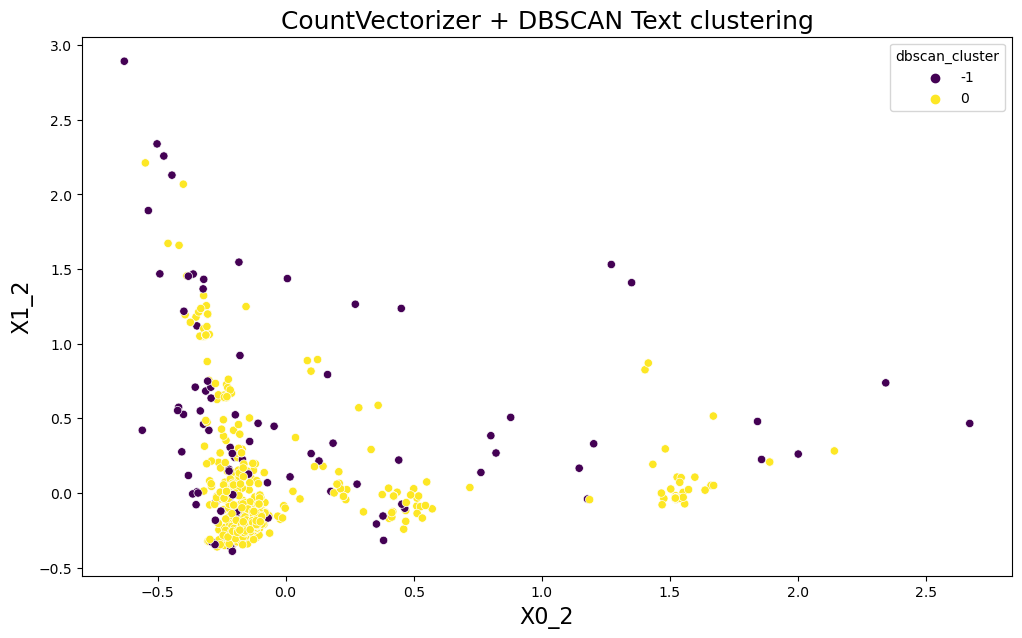

In [136]:
# set image size
plt.figure(figsize=(12, 7))
# set a title
plt.title("CountVectorizer + DBSCAN Text clustering", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0_2", fontdict={"fontsize": 16})
plt.ylabel("X1_2", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df, x='x0_2', y='x1_2', hue='dbscan_cluster', palette="viridis")
plt.show()

In [137]:
#number of clusters
N_clus = len(set(db_clusters))-(1 if -1 in db_clusters else 0)
print('Estimated no. of clusters: %d' % N_clus) 

Estimated no. of clusters: 1


In [138]:
#identify noise
n_noise = list(db_clusters).count(-1)
print('Estimated no. of noise points: %d' % n_noise)

Estimated no. of noise points: 100


**Observations:**

- Even though the silhoutte score is highest compared to KMeans, from the visualization, there is no distinct clustering. 
- The points highlighted in purple are actually noise. 
- Out of 846 comments, 100 were filtered as noise. 
- We would continue with the results from KMeans to proceed with further analysis. 

### Affinity Propagation Clustering Algorithm

This clustering algorithm is completely different from the others in the way that it clusters data. 

Each data point communicates with all of the other data points to let each other know how similar they are and that starts to reveal the clusters in the data. You don't have to tell this algoritm how many clusters to expect in the initialization parameters.

As messages are sent between data points, sets of data called *exemplars* are found and they represent the clusters.

In [139]:
#define the model 
model = AffinityPropagation(damping = 0.7)

In [140]:
#train the model with CountVectorizer
model.fit(X1)

AffinityPropagation(damping=0.7)

In [141]:
#assign each data point to a cluster
result = model.predict(X1)

In [142]:
#get all of the unique clusters
clusters = unique(result)

In [143]:
clusters

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132])

**Observations:**

- Too many clusters, which would not be insightful.

### Latent Dirichlet Allocation (LDA)

**Topic Modelling**

Often, just having clusters of documents is not enough. Topic modelling is done using LDA (Latent Dirichlet Allocation). Topic modelling refers to the task of identifying topics that best describes a set of documents. The aim of LDA is to find topics a document belongs to, based on the words in it. 

Latent refers to hidden variables, a Dirichlet distribution is a probability distribution over other probability distributions and allocation means that some values are allocated based on the two. 

Topic modelling is an unsupervised approach of recognizing or extracting the topics by detecting the patterns like clustering algorithms which divides the data into different parts. The same happens in Topic modelling in which we get to know the different topics in the document. This is done by extracting the patterns of word clusters and frequencies of words in the document.

In [144]:
# Parameters tuning using Grid Search
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

grid_params = {'n_components' : list(range(4,10))}

# LDA model
lda = LatentDirichletAllocation()
lda_model = GridSearchCV(lda,param_grid=grid_params)
lda_model.fit(X1)

# Estimators for LDA model
lda_model1 = lda_model.best_estimator_
print("Best LDA model's params" , lda_model.best_params_)
print("Best log likelihood Score for the LDA model",lda_model.best_score_)
print("LDA model Perplexity on train data", lda_model1.perplexity(X))

Best LDA model's params {'n_components': 4}
Best log likelihood Score for the LDA model -3731.566729064394
LDA model Perplexity on train data 218.1456544007165


In [145]:
stop_words = stopwords.words('english')
stop_words.extend(['help', 'hope', 'donated', 'just', 'let', 'ha', 'wa', 'don', 'donate', 'donation', 'soon'])

In [146]:
def sent_to_words(sentences):
    for sentence in sentences:
        #deacc = True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        

def remove_stopwords(texts):
    return[[word for word in simple_preprocess(str(doc))
           if word not in stop_words] for doc in texts]

In [147]:
data = df.cleaned_lem.values.tolist()
data_words = list(sent_to_words(data))

In [148]:
#remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['imagine', 'joceline', 'parent', 'definitely', 'wish', 'joceline', 'get', 'treatment', 'wish', 'someone', 'someone', 'pray', 'joceline', 'get', 'better']


In [149]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 2), (3, 1), (4, 3), (5, 1), (6, 1), (7, 2), (8, 1), (9, 2)]


In [150]:
from pprint import pprint

# number of topics
num_topics = 4

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.026*"family" + 0.017*"recovery" + 0.016*"speedy" + 0.015*"support" + '
  '0.012*"give" + 0.011*"life" + 0.011*"get" + 0.010*"back" + 0.010*"want" + '
  '0.010*"love"'),
 (1,
  '0.022*"get" + 0.019*"well" + 0.016*"little" + 0.015*"life" + 0.015*"may" + '
  '0.014*"small" + 0.012*"family" + 0.010*"bless" + 0.010*"need" + '
  '0.010*"baby"'),
 (2,
  '0.025*"need" + 0.023*"want" + 0.016*"give" + 0.012*"small" + 0.012*"one" + '
  '0.011*"people" + 0.011*"see" + 0.011*"get" + 0.010*"every" + 0.010*"child"'),
 (3,
  '0.025*"god" + 0.019*"wish" + 0.018*"recover" + 0.017*"well" + 0.016*"get" + '
  '0.014*"need" + 0.014*"strong" + 0.013*"others" + 0.013*"bless" + '
  '0.011*"recovery"')]


In [151]:
import pyLDAvis.gensim_models
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/Users/shuxiangoh/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/shuxiangoh/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/shuxiangoh/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/shuxiangoh/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/shuxiangoh/opt/anaconda3/lib/python3.9/site-packa

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.009330 -0.081836       1        1  27.566203
1     -0.012865  0.037557       2        1  26.024777
3      0.079874  0.016529       3        1  24.909897
2     -0.057679  0.027750       4        1  21.499123, topic_info=                Term       Freq      Total Category  logprob  loglift
136             want  50.000000  50.000000  Default  30.0000  30.0000
202              god  55.000000  55.000000  Default  29.0000  29.0000
9               wish  39.000000  39.000000  Default  28.0000  28.0000
149          recover  42.000000  42.000000  Default  27.0000  27.0000
52              need  73.000000  73.000000  Default  26.0000  26.0000
164          support  40.000000  40.000000  Default  25.0000  25.0000
55            others  30.000000  30.000000  Default  24.0000  24.0000
80           sharing  12.000000  12.000000  Default  23.0000  23.0000
17               bit  14.000000  14.000000  Default  22.0000  22.0000
19             every  23.000000  23.000000  Default  21.0000  21.0000
130              one  28.000000  28.000000  Default  20.0000  20.0000
216            bless  40.000000  40.000000  Default  19.0000  19.0000
143             give  50.000000  50.000000  Default  18.0000  18.0000
33             small  44.000000  44.000000  Default  17.0000  17.0000
146             back  22.000000  22.000000  Default  16.0000  16.0000
37            family  76.000000  76.000000  Default  15.0000  15.0000
385             good  33.000000  33.000000  Default  14.0000  14.0000
140           little  46.000000  46.000000  Default  13.0000  13.0000
115              see  27.000000  27.000000  Default  12.0000  12.0000
15              well  68.000000  68.000000  Default  11.0000  11.0000
279         blessing  18.000000  18.000000  Default  10.0000  10.0000
237         recovery  52.000000  52.000000  Default   9.0000   9.0000
131             part  17.000000  17.000000  Default   8.0000   8.0000
76            caring   7.000000   7.000000  Default   7.0000   7.0000
119            world  25.000000  25.000000  Default   6.0000   6.0000
30              make  19.000000  19.000000  Default   5.0000   5.0000
238           speedy  44.000000  44.000000  Default   4.0000   4.0000
96           society  13.000000  13.000000  Default   3.0000   3.0000
14            strong  39.000000  39.000000  Default   2.0000   2.0000
100         fighting  12.000000  12.000000  Default   1.0000   1.0000
444             audi   3.487797   4.120642   Topic1  -6.0397   1.1218
569              mom   3.476298   4.120470   Topic1  -6.0430   1.1186
1074         foreign   2.672771   3.293468   Topic1  -6.3058   1.0798
369       regardless   2.636081   3.292686   Topic1  -6.3197   1.0662
711           around   3.189810   4.115350   Topic1  -6.1290   1.0338
331        malaysian   6.836427   9.036298   Topic1  -5.3667   1.0096
1170              ah   1.853993   2.466075   Topic1  -6.6716   1.0033
688        secondary   1.853002   2.465959   Topic1  -6.6721   1.0028
870            study   1.852293   2.466005   Topic1  -6.6725   1.0024
1028           leste   1.851802   2.465978   Topic1  -6.6728   1.0022
1033            chan   1.849281   2.465861   Topic1  -6.6742   1.0008
371         sunshine   1.845833   2.465753   Topic1  -6.6760   0.9990
421         suitable   1.845783   2.465819   Topic1  -6.6761   0.9990
1019          corner   1.843900   2.465749   Topic1  -6.6771   0.9980
962         critical   1.837048   2.465744   Topic1  -6.6808   0.9942
935             amit   1.821903   2.465129   Topic1  -6.6891   0.9862
344           effort   7.294232   9.875577   Topic1  -5.3019   0.9856
936              bha   1.816572   2.464946   Topic1  -6.6920   0.9834
381          wishing   6.033088   8.214434   Topic1  -5.4917   0.9799
892          special   1.809506   2.465159   Topic1  -6.6959   0.9794
531        singapore   6.510964   9.030171   Topic1  -5.4155   

### Conclusion and Recommendation

**5. BERT (Bidirectional Encoder Representations from Transformers)**

BERT is an ML/NLP techique developed by Google that uses a transformer based ML model to convert phrases, words, etc into vectors. The BERT model created by Google is trained on entire Wikipedia which is like millions of documents and BERT already knows the context of the sentences. Key differences between TF-IDF and BERT are as follows: TF-IDF does not take into account semantic meaning or context of the words whereas BERT does.

Proper language representation is key for general-purpose language understanding by machines. Context-free models such as *word2vec* or *GloVe* generate a single word embedding representation for each word in the vocabulary. For example, the word “bank” would have the same representation in “bank deposit” and in “riverbank”. Contextual models instead generate a representation of each word that is based on the other words in the sentence.

BERT, as a contextual model, captures these relationships in a bidirectional way.




## BERT (Bidirectional Encoder Representations from Transformers) Model

The BERT model created by Google is trained on entire Wikipedia which is like millions of documents and BERT already knows the context of the sentences. 

**Why do we need BERT?**

Proper language representation is key for general-purpose language understanding by machines. Context-free models such as *word2vec* or *GloVe* generate a single word embedding representation for each word in the vocabulary. For example, the word “bank” would have the same representation in “bank deposit” and in “riverbank”. Contextual models instead generate a representation of each word that is based on the other words in the sentence.

BERT, as a contextual model, captures these relationships in a bidirectional way.




**1. One-hot encoding**

A boolean vector encoding method that marks a particular vector index with a value of true (1) if the token exists in the document and false (0) if it does not. One-hot encoding reduces the imbalance issue of the distribution of tokens, simplifying a document to its constituent components. Note that we could also use CountVectorizer(binary=True) to achieve one-hot encoding. This is a simple representation of text and can be used in different machine learning models. However, many models perform much better with other techniques since this does not capture any information other than if a word exists or not. 

**4. Distributed representation (Word2Vec)**

When document similarity is important in the context of an application, we instead encode text along a continuous scale with a distributed representation. This means that the resulting document vector is not a simple mapping from token position to token score. Instead, the document is represented in a feature space that has been embedded to represent word similarity. The complexity of this space (and the resulting vector length) is the product of how the mapping to that representation is learned. The complexity of this space (and the resulting vector length) is the product of how that representation is trained and not directly tied to the document itself.

Word2vec implements a word embedding model that enables us to create these kinds of distributed representations. The word2vec algorithm trains word representations based on either a continuous bag-of-words (CBOW) or skip-gram model, such that words are embedded in space along with similar words based on their context. In Word2vec method, unlike One-hot encoding and TF-IDF methods, unsupervised learning process is performed. Unlabelled data is trained via artificial neural networks to create the Word2vec model that generates word vectors. 

https://towardsdatascience.com/word-embedding-techniques-word2vec-and-tf-idf-explained-c5d02e34d08

#### Distribution - based

With a distribution-based clustering approach, all of the data points are considered parts of a cluster based on the probability that they belong to a given cluster.

It works like this: there is a center-point, and as the distance of a data point from the center increases, the probability of it being a part of that cluster decreases.

#### Hierarchical - based

Hierarchical-based clustering is typically used on hierarchical data, like you would get from a company database or taxonomies. It builds a tree of clusters so everything is organized from the top-down.

This is more restrictive than the other clustering types, but it's perfect for specific kinds of data sets.

